# Capstone 1: Airbnb Price Analysis # 
## Cleaning and Pre-Processing ##

**Importing necessary libraries and reading in listing data**

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn import preprocessing, svm, model_selection, ensemble, datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb
from xgboost import plot_importance
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from string import ascii_letters

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('listings.csv', index_col='id', low_memory=False)
pd.set_option('display.max_columns', len(df.columns))

In [3]:
df.sort_index(inplace=True)
df.head(3)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2265,https://www.airbnb.com/rooms/2265,20200219033646,2020-02-19,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,100%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,NaN,Austin,TX,78702,Austin,"Austin, TX",US,United States,30.27750,-97.71398,f,House,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$225.00,NaN,NaN,$500.00,$100.00,4,$30.00,30,90,30,30,90,90,30.0,90.0,7 months ago,t,0,0,0,0,2020-02-19,24,1,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
5245,https://www.airbnb.com/rooms/5245,20200219033646,2020-02-19,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,100%,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/us

I noticed that there's some columns that use 't' or 'f' for True and False. I will convert those to 1 and 0 respectively to become more Pythonic.

In [4]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

Saving the latitude and longitude coordinate columns into a new df to use for later.

In [5]:
coordinates = df[['latitude','longitude']]

In [6]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'has_availability', 'host_has_profile_pic', 'is_business_travel_ready','requires_license','zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
df = df.drop(drop_cols, axis=1)

In [7]:
print(df.shape)
print(df.dtypes.value_counts())

(11520, 52)
object     22
float64    16
int64      14
dtype: int64


The listings dataframe now contains 11,520 rows and 52 columns with mixed data types.

In [8]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['host_is_superhost' 'host_listings_count' 'host_identity_verified'
 'neighbourhood_cleansed' 'neighbourhood_group_cleansed' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'square_feet' 'guests_included'
 'minimum_nights' 'maximum_nights' 'availability_30' 'availability_60'
 'availability_90' 'availability_365' 'number_of_reviews'
 'number_of_reviews_ltm' 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'instant_bookable' 'require_guest_profile_picture'
 'require_guest_phone_verification' 'reviews_per_month']


In [9]:
# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['experiences_offered' 'host_since' 'host_response_time'
 'host_response_rate' 'host_acceptance_rate' 'city' 'property_type'
 'room_type' 'bed_type' 'amenities' 'price' 'weekly_price' 'monthly_price'
 'security_deposit' 'cleaning_fee' 'extra_people' 'calendar_updated'
 'first_review' 'last_review' 'license' 'jurisdiction_names'
 'cancellation_policy']


Missing Data Heatmap

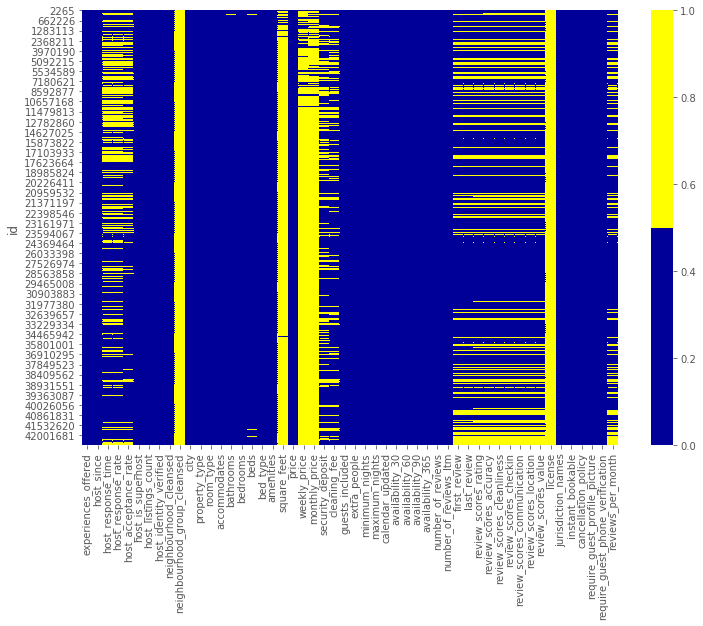

In [10]:
cols = df.columns[:] #
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

It's now clear that there are several columns that are completely empty of missing a large portion of data.

Listing percentages of missing data in each column

In [11]:
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

experiences_offered - 0.0%
host_since - 0.0%
host_response_time - 31.0%
host_response_rate - 31.0%
host_acceptance_rate - 23.0%
host_is_superhost - 0.0%
host_listings_count - 0.0%
host_identity_verified - 0.0%
neighbourhood_cleansed - 0.0%
neighbourhood_group_cleansed - 100.0%
city - 0.0%
property_type - 0.0%
room_type - 0.0%
accommodates - 0.0%
bathrooms - 0.0%
bedrooms - 0.0%
beds - 0.0%
bed_type - 0.0%
amenities - 0.0%
square_feet - 98.0%
price - 0.0%
weekly_price - 92.0%
monthly_price - 94.0%
security_deposit - 27.0%
cleaning_fee - 18.0%
guests_included - 0.0%
extra_people - 0.0%
minimum_nights - 0.0%
maximum_nights - 0.0%
calendar_updated - 0.0%
availability_30 - 0.0%
availability_60 - 0.0%
availability_90 - 0.0%
availability_365 - 0.0%
number_of_reviews - 0.0%
number_of_reviews_ltm - 0.0%
first_review - 21.0%
last_review - 21.0%
review_scores_rating - 22.0%
review_scores_accuracy - 22.0%
review_scores_cleanliness - 22.0%
review_scores_checkin - 22.0%
review_scores_communication -

In [12]:
drop_cols = ['neighbourhood_group_cleansed', 'square_feet','weekly_price', 'monthly_price', 'license']
df = df.drop(drop_cols, axis=1)

In [13]:
df.columns

Index(['experiences_offered', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'city', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       're

# Cleaning Individual Columns #

**Column Descriptions**

*Description of each column:*
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the zip code that the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

**experiences_offered**

In [14]:
df.experiences_offered.value_counts(dropna=False)

none    11520
Name: experiences_offered, dtype: int64

In [15]:
df.drop('experiences_offered', axis=1, inplace=True)

**host_since**

In [16]:
df.host_since.value_counts(dropna=False)

2016-11-19    245
2018-10-08    144
2017-02-01     86
2017-01-03     85
2013-02-04     84
             ... 
2009-07-11      1
2015-04-09      1
2020-01-23      1
2018-06-08      1
2018-07-05      1
Name: host_since, Length: 2847, dtype: int64

This column uses the date that a host joined as a data point. I'm going to convert this column to an integer value that represents the number of days the host has been on Airbnb and store it in a new columns.

In [17]:
# Converting to datetime object
df['host_since'] = pd.to_datetime(df['host_since'])
# Calcuating the number of days a host has been active on Airbnb
# I used 2/19/2020 as the end date since that was the date this data was scraped
df['days_as_host'] = (dt(2020, 2, 19) - df.host_since).astype('timedelta64[D]')


**host_response_time**

In [18]:
# Function to get basic information on each column
def col_info(col):
    pct_missing = np.mean(df[col].isnull())
    percentage = 'Missing Data: {}%'.format(round(pct_missing*100))
    value_counts = df[col].value_counts(dropna=False)
    unique_vals = 'Number of Unique Values: {}'.format(df[col].nunique())
    data_type = '\nData Type: {}'.format(df[col].dtype)
    
    return print("Column Name", col, data_type, unique_vals, percentage, "\nValue Counts", value_counts, sep='\n')


In [19]:
col_info('host_response_time')

Column Name
host_response_time

Data Type: object
Number of Unique Values: 4
Missing Data: 31.0%

Value Counts
within an hour        6331
NaN                   3598
within a few hours     937
within a day           540
a few days or more     114
Name: host_response_time, dtype: int64


In [20]:
df.host_response_time.fillna('unknown', inplace=True)

**host_response_rate**

In [21]:
col_info('host_response_rate')

Column Name
host_response_rate

Data Type: object
Number of Unique Values: 46
Missing Data: 31.0%

Value Counts
100%    6566
NaN     3598
99%      345
90%      114
98%      109
0%        84
92%       76
97%       75
95%       71
80%       53
96%       50
67%       40
50%       37
89%       29
94%       28
88%       26
93%       25
86%       25
85%       24
83%       22
75%       19
33%       15
60%       13
91%       12
70%       11
87%       11
56%        5
38%        3
64%        3
71%        3
82%        3
20%        3
55%        3
57%        3
72%        2
74%        2
25%        2
78%        1
73%        1
14%        1
17%        1
79%        1
63%        1
47%        1
44%        1
13%        1
10%        1
Name: host_response_rate, dtype: int64


Since there are so many unqiue values here, I will create a smaller number of bins to represent the data.

In [22]:
# Converting response rate to numeric column
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

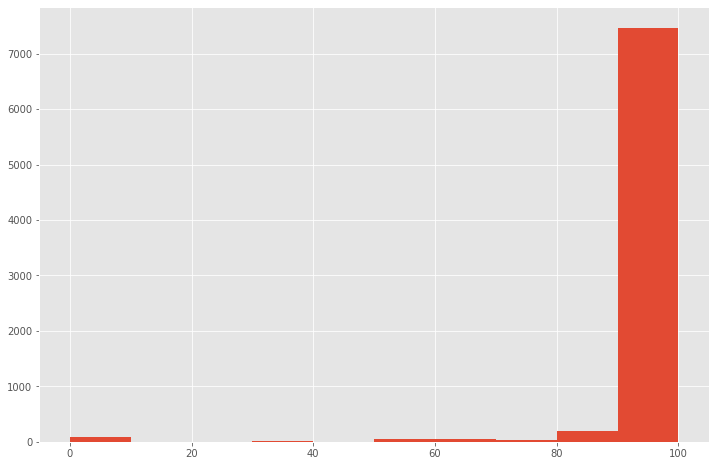

In [23]:
df.host_response_rate.hist(bins=10)

It's clear that most of the response rates lie within 90-100%.

In [24]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Calling function to see details of new column
col_info('host_response_rate')

Column Name
host_response_rate

Data Type: object
Number of Unique Values: 5
Missing Data: 0.0%

Value Counts
100%       6566
unknown    3598
90-99%      791
50-89%      415
0-49%       150
Name: host_response_rate, dtype: int64


**host_acceptance_rate**

Since there are so many unqiue values here, I will create 5 distinct ranges to bin the data.

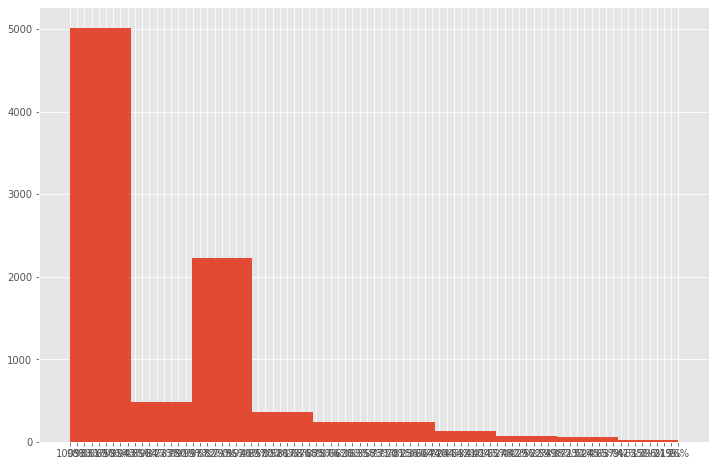

In [25]:
df.host_acceptance_rate.hist(bins=10)

In [26]:
# # Bin into four categories
# df.host_acceptance_rate = pd.cut(df.host_acceptance_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# # Converting to string
# df.host_acceptance_rate = df.host_acceptance_rate.astype('str')

# # Replace nulls with 'unknown'
# df.host_acceptance_rate.replace('nan', 'unknown', inplace=True)

# # Calling function to see details of new column
# col_info('host_acceptance_rate')

In [27]:
df.host_acceptance_rate.unique()

array(['100%', '98%', '93%', '83%', '61%', '69%', '50%', nan, '91%',
       '94%', '43%', '85%', '96%', '84%', '77%', '33%', '78%', '90%',
       '99%', '97%', '67%', '82%', '79%', '0%', '95%', '92%', '46%',
       '89%', '57%', '80%', '52%', '86%', '17%', '68%', '76%', '88%',
       '75%', '87%', '66%', '62%', '30%', '63%', '35%', '58%', '73%',
       '71%', '70%', '81%', '25%', '36%', '60%', '64%', '74%', '20%',
       '44%', '54%', '32%', '41%', '40%', '14%', '55%', '27%', '48%',
       '42%', '29%', '56%', '22%', '59%', '49%', '38%', '72%', '13%',
       '51%', '24%', '45%', '65%', '37%', '9%', '47%', '53%', '15%',
       '39%', '6%', '21%', '19%', '26%'], dtype=object)

**host_is_superhost**

In [28]:
col_info('host_is_superhost')

Column Name
host_is_superhost

Data Type: float64
Number of Unique Values: 2
Missing Data: 0.0%

Value Counts
0.0    7663
1.0    3855
NaN       2
Name: host_is_superhost, dtype: int64


**host_listings_count**

In [29]:
col_info('host_listings_count')

Column Name
host_listings_count

Data Type: float64
Number of Unique Values: 84
Missing Data: 0.0%

Value Counts
1.0      5202
2.0      1559
0.0       877
3.0       717
4.0       405
         ... 
232.0       1
129.0       1
18.0        1
219.0       1
92.0        1
Name: host_listings_count, Length: 85, dtype: int64


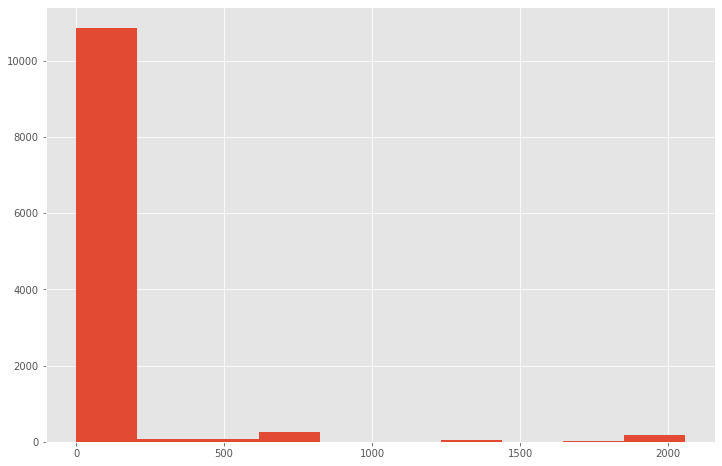

In [30]:
df.host_listings_count.hist()

In [31]:
df.host_listings_count = pd.qcut(df.host_listings_count, q=10, duplicates='drop', labels=['1','1-2','2-3','3-7','7-58','58-2056'])

In [32]:
col_info('host_listings_count')

Column Name
host_listings_count

Data Type: category
Number of Unique Values: 6
Missing Data: 0.0%

Value Counts
1          6079
1-2        1559
58-2056    1133
7-58       1112
3-7         918
2-3         717
NaN           2
Name: host_listings_count, dtype: int64


In [33]:
df[df.host_listings_count.isnull()]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,city,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,days_as_host
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4356661,NaT,unknown,unknown,NaN,NaN,NaN,NaN,78704,Austin,Apartment,Entire home/apt,2,1.0,1.0,1.0,Airbed,"{""Air conditioning"",""Wheelchair accessible"",Po...",$75.00,NaN,NaN,1,$0.00,1,1125,53 months ago,0,0,0,0,1,0,2015-08-13,2015-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""Texas State""}",0,strict_14_with_grace_period,0,0,0.02,NaN
8214182,NaT,unknown,unknown,NaN,NaN,NaN,NaN,78741,Austin,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$26.00,NaN,NaN,1,$0.00,1,5,51 months ago,0,0,0,0,4,0,2015-09-07,2015-09-24,93.0,9.0,9.0,10.0,10.0,10.0,10.0,"{""Texas State""}",0,flexible,0,0,0.07,NaN


**host_identity_verified**

In [34]:
col_info('host_identity_verified')

Column Name
host_identity_verified

Data Type: float64
Number of Unique Values: 2
Missing Data: 0.0%

Value Counts
0.0    6056
1.0    5462
NaN       2
Name: host_identity_verified, dtype: int64


It looks like there are slightly more hosts with unverified accounts compared to hosts with verified accounts

**neighbourhood_cleansed**

In [35]:
col_info('neighbourhood_cleansed')

Column Name
neighbourhood_cleansed

Data Type: int64
Number of Unique Values: 44
Missing Data: 0.0%

Value Counts
78704    2214
78702    1506
78741     785
78701     719
78705     651
78703     620
78745     535
78751     484
78723     340
78746     284
78757     242
78758     233
78721     224
78734     222
78722     218
78744     188
78748     169
78756     136
78731     135
78759     127
78749     127
78752     119
78753     104
78729     104
78737      99
78754      96
78727      90
78724      80
78733      75
78728      70
78736      63
78717      62
78725      60
78735      54
78750      50
78738      48
78732      45
78747      45
78730      40
78739      33
78726      13
78742       6
78712       3
78719       2
Name: neighbourhood_cleansed, dtype: int64


It appears that there are no missing values for this column, which is good.

**city**

In [36]:
col_info('city')

Column Name
city

Data Type: object
Number of Unique Values: 24
Missing Data: 0.0%

Value Counts
Austin                    11369
Lakeway                      66
West Lake Hills              26
Sunset Valley                10
Pflugerville                  8
Bee Cave                      6
The Hills                     6
Austin                        4
Dripping Springs              3
Rollingwood                   2
Lake Travis                   2
Manchaca                      2
NaN                           2
Spicewood                     2
AUSTIN                        2
point venture                 1
Travis County                 1
Westlake Hills, Austin        1
Round Rock                    1
Driftwood                     1
Anderson Mill                 1
Downtown Austin               1
Cedar Park                    1
austin                        1
Bouldin, Austin               1
Name: city, dtype: int64


There appears to be slight variations in how Austin, TX is entered. I will group everything into Austin and drop the outlying cities.

In [37]:
df.city = df.city.str.upper()

In [38]:
col_info('city')

Column Name
city

Data Type: object
Number of Unique Values: 22
Missing Data: 0.0%

Value Counts
AUSTIN                    11372
LAKEWAY                      66
WEST LAKE HILLS              26
SUNSET VALLEY                10
PFLUGERVILLE                  8
BEE CAVE                      6
THE HILLS                     6
AUSTIN                        4
DRIPPING SPRINGS              3
MANCHACA                      2
SPICEWOOD                     2
ROLLINGWOOD                   2
NaN                           2
LAKE TRAVIS                   2
CEDAR PARK                    1
ROUND ROCK                    1
WESTLAKE HILLS, AUSTIN        1
DRIFTWOOD                     1
POINT VENTURE                 1
TRAVIS COUNTY                 1
BOULDIN, AUSTIN               1
DOWNTOWN AUSTIN               1
ANDERSON MILL                 1
Name: city, dtype: int64


In [39]:
df.city.unique()

array(['AUSTIN', nan, 'WEST LAKE HILLS', 'SUNSET VALLEY', 'LAKEWAY',
       'ROLLINGWOOD', 'THE HILLS', 'MANCHACA', 'BEE CAVE',
       'ANDERSON MILL', 'DRIPPING SPRINGS', 'AUSTIN ', 'SPICEWOOD',
       'BOULDIN, AUSTIN', 'ROUND ROCK', 'WESTLAKE HILLS, AUSTIN',
       'DRIFTWOOD', 'LAKE TRAVIS', 'DOWNTOWN AUSTIN', 'PFLUGERVILLE',
       'CEDAR PARK', 'TRAVIS COUNTY', 'POINT VENTURE'], dtype=object)

In [40]:
mapped_cols_keep = {'AUSTIN':'AUSTIN', 'AUSTIN ':'AUSTIN', 'DOWNTOWN AUSTIN':'AUSTIN'}
df.city = df.city.map(mapped_cols_keep)

In [41]:
df.city.dropna(inplace=True)

**property_type**

In [42]:
col_info('property_type')

Column Name
property_type

Data Type: object
Number of Unique Values: 35
Missing Data: 0.0%

Value Counts
House                 5069
Apartment             3051
Condominium           1057
Guesthouse             522
Townhouse              418
Bungalow               298
Guest suite            266
Serviced apartment     169
Loft                   131
Camper/RV               90
Cottage                 69
Tiny house              60
Resort                  49
Villa                   43
Other                   38
Boutique hotel          31
Hostel                  28
Aparthotel              24
Cabin                   19
Bed and breakfast       18
Tent                    12
Campsite                 9
Farm stay                9
Boat                     7
Hotel                    5
Treehouse                5
Yurt                     5
Barn                     4
Tipi                     3
Dome house               3
Houseboat                2
Chalet                   2
Bus                      2
Ear

There are a lot of different categories for the type of house the listing is. I will try to get this down to 5-7 different categories.

In [43]:
df.property_type = df.property_type.str.upper()
df.property_type.unique()

array(['HOUSE', 'GUESTHOUSE', 'GUEST SUITE', 'CONDOMINIUM', 'APARTMENT',
       'TOWNHOUSE', 'BUNGALOW', 'LOFT', 'OTHER', 'CABIN',
       'BED AND BREAKFAST', 'CAMPSITE', 'TENT', 'VILLA', 'CAMPER/RV',
       'COTTAGE', 'TINY HOUSE', 'SERVICED APARTMENT', 'BARN', 'FARM STAY',
       'BOUTIQUE HOTEL', 'YURT', 'DOME HOUSE', 'BUS', 'TIPI', 'TREEHOUSE',
       'BOAT', 'HOSTEL', 'APARTHOTEL', 'CHALET', 'HOUSEBOAT', 'RESORT',
       'HOTEL', 'EARTH HOUSE', 'NATURE LODGE'], dtype=object)

In [44]:
propery_type_dict = {'GUESTHOUSE' : 'HOUSE',
                     'GUEST SUITE' : 'HOUSE', 
                     'CONDOMINIUM' : 'APARTMENT/CONDO',
                     'APARTMENT' : 'APARTMENT/CONDO',
                     'TOWNHOUSE' : 'HOUSE',
                     'BUNGALOW' : 'HOUSE',
                     'LOFT' : 'HOUSE',
                     'CABIN' : 'HOUSE',
                     'BED AND BREAKFAST' : 'HOTEL',
                     'CAMPSITE' : 'OTHER',
                     'TENT' : 'OTHER',
                     'VILLA' : 'HOUSE',
                     'CAMPER/RV' : 'OTHER',
                     'COTTAGE' : 'HOUSE',
                     'TINY HOUSE' : 'HOUSE',
                     'SERVICED APARTMENT' : 'APARTMENT/CONDO',
                     'BARN' : 'OTHER',
                     'FARM STAY' : 'OTHER',
                     'BOUTIQUE HOTEL' : 'HOTEL',
                     'YURT' : 'OTHER', 
                     'DOME HOUSE' : 'HOUSE', 
                     'BUS' : 'OTHER', 
                     'TIPI' : 'OTHER', 
                     'TREEHOUSE' : 'OTHER',
                     'BOAT' : 'OTHER',
                     'HOSTEL' : 'OTHER',
                     'APARTHOTEL' : 'APARTMENT/CONDO',
                     'CHALET' : 'HOUSE',
                     'HOUSEBOAT' : 'OTHER',
                     'RESORT' : 'HOTEL',
                     'EARTH HOUSE' : 'HOUSE',
                     'NATURE LODGE' : 'OTHER'
                    }

df.property_type.replace(propery_type_dict, inplace = True)
col_info('property_type')

Column Name
property_type

Data Type: object
Number of Unique Values: 4
Missing Data: 0.0%

Value Counts
HOUSE              6901
APARTMENT/CONDO    4301
OTHER               215
HOTEL               103
Name: property_type, dtype: int64


**room_type**

In [45]:
col_info('room_type')

Column Name
room_type

Data Type: object
Number of Unique Values: 4
Missing Data: 0.0%

Value Counts
Entire home/apt    8700
Private room       2587
Shared room         179
Hotel room           54
Name: room_type, dtype: int64


In [46]:
df['room_type'] = df['room_type'].str.upper()
df['room_type'] = df['room_type'].replace('HOTEL ROOM', 'PRIVATE ROOM')

In [47]:
col_info('room_type')

Column Name
room_type

Data Type: object
Number of Unique Values: 3
Missing Data: 0.0%

Value Counts
ENTIRE HOME/APT    8700
PRIVATE ROOM       2641
SHARED ROOM         179
Name: room_type, dtype: int64


**accommodates**

In [48]:
col_info('accommodates')

Column Name
accommodates

Data Type: int64
Number of Unique Values: 26
Missing Data: 0.0%

Value Counts
2     3187
4     2535
6     1678
3      935
8      690
5      630
1      483
10     416
16     247
7      244
12     172
9      104
14      78
11      42
13      30
15      27
18       4
21       4
24       3
19       2
20       2
32       2
28       2
33       1
25       1
17       1
Name: accommodates, dtype: int64


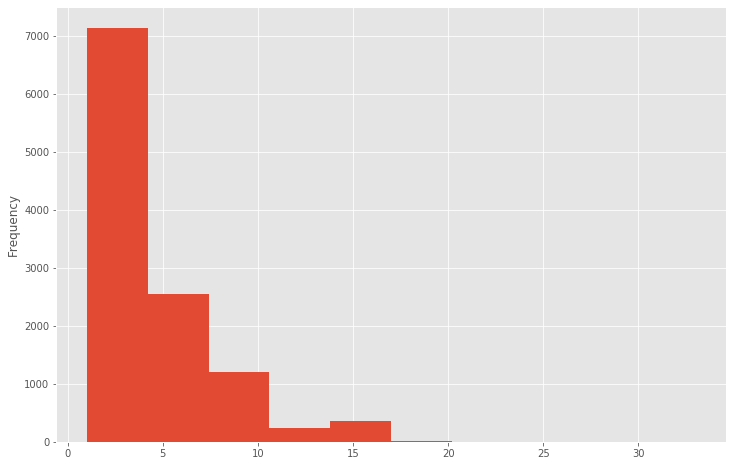

In [49]:
df.accommodates.plot(kind='hist')

Most of the data falls between 0-10 people.

**bathrooms**

In [50]:
col_info('bathrooms')

Column Name
bathrooms

Data Type: float64
Number of Unique Values: 21
Missing Data: 0.0%

Value Counts
1.0     6751
2.0     2258
2.5      775
1.5      762
3.0      402
3.5      183
4.0      139
4.5       73
5.0       47
0.0       31
6.0       21
5.5       21
0.5       14
NaN       14
6.5       14
8.0        5
7.0        4
7.5        2
17.0       1
9.0        1
11.0       1
9.5        1
Name: bathrooms, dtype: int64


In [51]:
df.bathrooms.dropna(inplace=True)

**bedrooms**

In [52]:
col_info('bedrooms')

Column Name
bedrooms

Data Type: float64
Number of Unique Values: 16
Missing Data: 0.0%

Value Counts
1.0     5459
2.0     2714
3.0     1586
0.0      697
4.0      679
5.0      228
6.0       86
7.0       30
8.0       16
9.0        9
10.0       6
NaN        5
15.0       1
12.0       1
14.0       1
13.0       1
23.0       1
Name: bedrooms, dtype: int64


In [53]:
df.bedrooms.dropna(inplace=True)

Dropped the 5 missing values.

**beds**

In [54]:
col_info('beds')

Column Name
beds

Data Type: float64
Number of Unique Values: 33
Missing Data: 0.0%

Value Counts
1.0      4404
2.0      2973
3.0      1796
4.0       818
5.0       437
6.0       288
0.0       168
7.0       156
8.0       105
10.0       76
9.0        68
11.0       59
NaN        40
12.0       36
13.0       18
14.0       16
16.0       14
15.0       11
18.0        7
17.0        6
19.0        5
22.0        4
25.0        2
26.0        2
24.0        2
39.0        1
28.0        1
20.0        1
33.0        1
132.0       1
27.0        1
36.0        1
61.0        1
30.0        1
Name: beds, dtype: int64


In [55]:
df.beds.fillna(df.beds.median(), inplace=True)

In [56]:
col_info('beds')

Column Name
beds

Data Type: float64
Number of Unique Values: 33
Missing Data: 0.0%

Value Counts
1.0      4404
2.0      3013
3.0      1796
4.0       818
5.0       437
6.0       288
0.0       168
7.0       156
8.0       105
10.0       76
9.0        68
11.0       59
12.0       36
13.0       18
14.0       16
16.0       14
15.0       11
18.0        7
17.0        6
19.0        5
22.0        4
24.0        2
26.0        2
25.0        2
39.0        1
28.0        1
33.0        1
132.0       1
27.0        1
36.0        1
30.0        1
61.0        1
20.0        1
Name: beds, dtype: int64


Since there were 40 missing data points, I decided to fill them with the column median rather than dropping them. I also noticed that there is one entry with 132 beds. This columns may need further inspection.

**bed_type**

In [57]:
col_info('bed_type')

Column Name
bed_type

Data Type: object
Number of Unique Values: 5
Missing Data: 0.0%

Value Counts
Real Bed         11407
Futon               43
Airbed              41
Pull-out Sofa       18
Couch               11
Name: bed_type, dtype: int64


Almost 100% of entries have real bed as the bed type so this column is not very useful and will be dropped.

**amenities**

Amenities is a behemoth of a column. There is a bunch of key information buried in this column for each listing entry that will have a great impact on the price of the rental.

In [58]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Free parking on premises","Paid parking off premises",Breakfast,"Pets live on this property",Dog(s),"Free street parking",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Lockbox,"Private entrance","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Garden or backyard"}'],
      dtype=object)

In [59]:
amenity_replace_dict = {'}':',', '{':'', '"':''}

# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)

for x, y in amenity_replace_dict.items():
    amenities_list_string = amenities_list_string.replace(x, y)
    
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set


{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air hockey table',
 'Alfresco bathtub',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Bar',
 'Barbecue utensils',
 'Basketball court',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach',
 'Beach chairs',
 'Beach essentials',
 'Beach volleyball',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Bocce ball court',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Central air conditioning',
 'Changing table',
 'Charcoal barbeque',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'D

In [60]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\ZachP\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [61]:
col_list = list(df.columns)
for i, item in enumerate(col_list):
    print(i,item)

0 host_since
1 host_response_time
2 host_response_rate
3 host_acceptance_rate
4 host_is_superhost
5 host_listings_count
6 host_identity_verified
7 neighbourhood_cleansed
8 city
9 property_type
10 room_type
11 accommodates
12 bathrooms
13 bedrooms
14 beds
15 bed_type
16 amenities
17 price
18 security_deposit
19 cleaning_fee
20 guests_included
21 extra_people
22 minimum_nights
23 maximum_nights
24 calendar_updated
25 availability_30
26 availability_60
27 availability_90
28 availability_365
29 number_of_reviews
30 number_of_reviews_ltm
31 first_review
32 last_review
33 review_scores_rating
34 review_scores_accuracy
35 review_scores_cleanliness
36 review_scores_checkin
37 review_scores_communication
38 review_scores_location
39 review_scores_value
40 jurisdiction_names
41 instant_bookable
42 cancellation_policy
43 require_guest_profile_picture
44 require_guest_phone_verification
45 reviews_per_month
46 days_as_host
47 check_in_24h
48 air_conditioning
49 high_end_electronics
50 bbq
51 balco

In [62]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,47:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'nature_and_views', 'host_greeting', 'smoking_allowed', 'accessible']


In [63]:
df.columns[46:]

Index(['check_in_24h', 'air_conditioning', 'bbq', 'balcony', 'bed_linen',
       'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'gym', 'child_friendly', 'parking', 'outdoor_space',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in', 'event_suitable'],
      dtype='object')

**price**

In [64]:
col_info('price')

Column Name
price

Data Type: object
Number of Unique Values: 690
Missing Data: 0.0%

Value Counts
$150.00      380
$100.00      335
$200.00      301
$250.00      263
$75.00       261
            ... 
$1,025.00      1
$463.00        1
$452.00        1
$1,139.00      1
$580.00        1
Name: price, Length: 690, dtype: int64


In [65]:
#converting strings representing price of listign to integers
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",","")
df.price = df.price.astype('int64')

In [66]:
df.price.min()

0

In [67]:
df.price.max()

25000

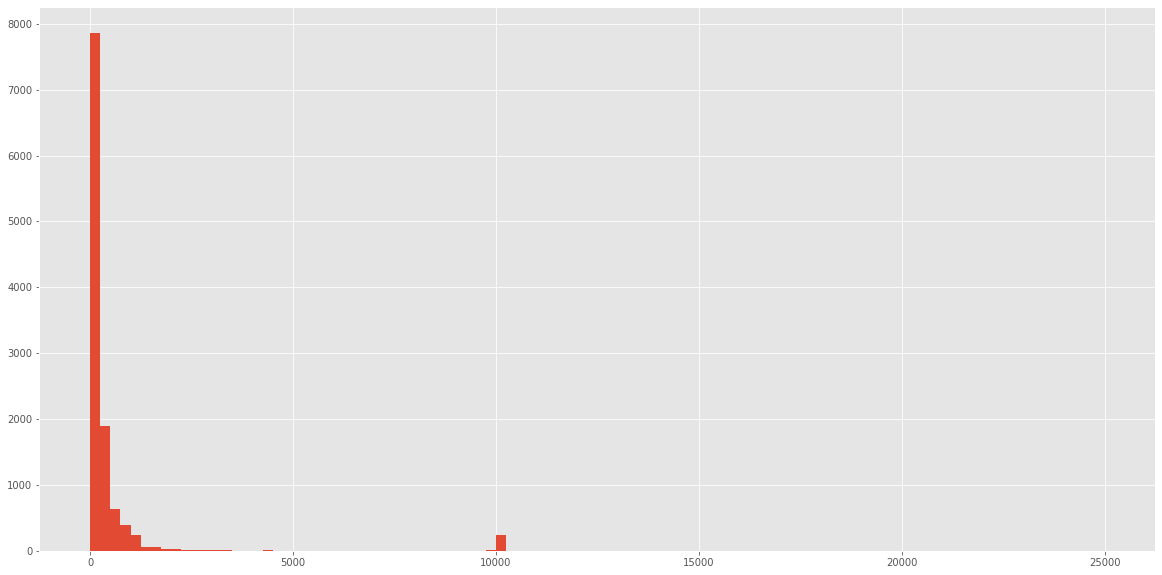

In [68]:
_ = plt.figure(figsize=(20,10))
_ = df.price.hist(bins=100)

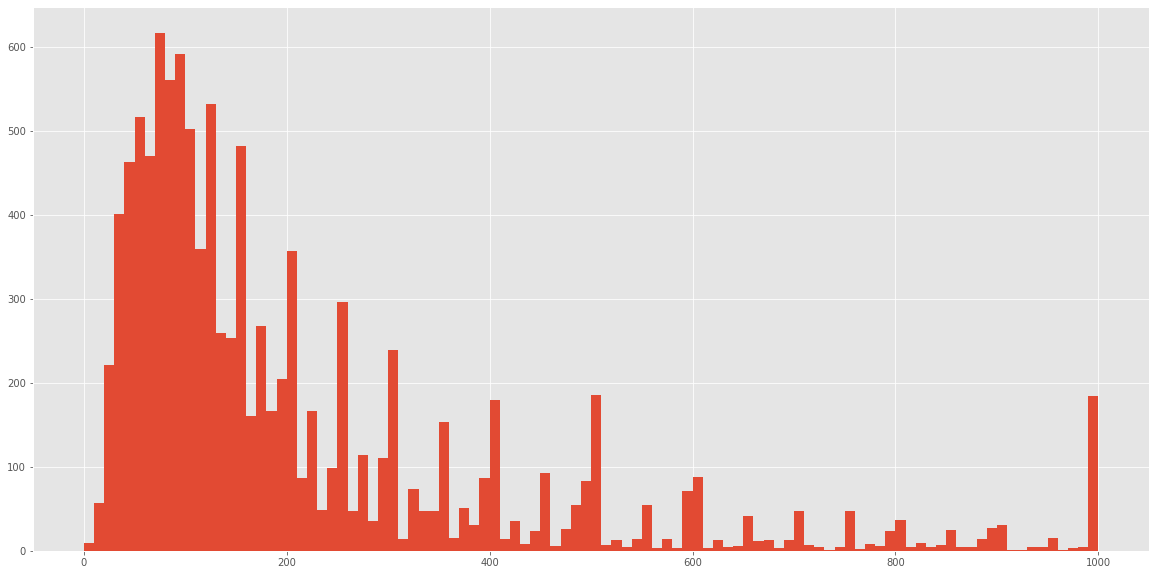

In [69]:
_ = plt.figure(figsize=(20,10))
_ = df.price.hist(bins=100, range=(0,1000))

In [70]:
# Replacing values under $10 with $10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
df.loc[df.price >= 1000, 'price'] = 1000


In [71]:
# dropping listings > $1000 per night since they will skew results
df = df[df['price'] != 1000]

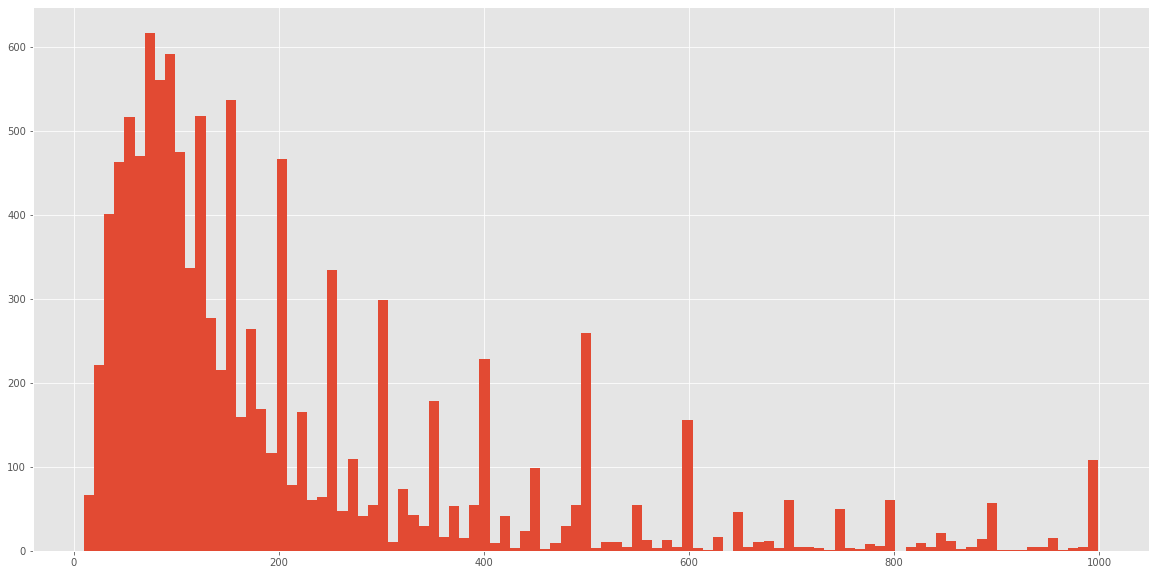

In [72]:
_ = plt.figure(figsize=(20,10))
_ = df.price.hist(bins=100)

In [73]:
# keeping for EDA
filtered_price = df[df['price'] <= 250]

In [74]:
# df = df[df['price'] <= 250]
# df.price

**security_deposit**

In [75]:
col_info('security_deposit')

Column Name
security_deposit

Data Type: object
Number of Unique Values: 99
Missing Data: 27.0%

Value Counts
$0.00        3164
NaN          2957
$500.00       843
$100.00       827
$200.00       580
             ... 
$4,500.00       1
$625.00         1
$1,550.00       1
$1,400.00       1
$259.00         1
Name: security_deposit, Length: 100, dtype: int64


In [76]:
#converting strings representing price of security deposit to integers
#replacing NaN with 0
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",","")
df.security_deposit = df.security_deposit.fillna(0)
df.security_deposit = df.security_deposit.astype('int64')

**cleaning_fee**

In [77]:
col_info('cleaning_fee')

Column Name
cleaning_fee

Data Type: object
Number of Unique Values: 236
Missing Data: 18.0%

Value Counts
NaN        1945
$100.00     807
$50.00      786
$0.00       565
$75.00      561
           ... 
$290.00       1
$131.00       1
$116.00       1
$193.00       1
$504.00       1
Name: cleaning_fee, Length: 237, dtype: int64


In [78]:
#converting strings to integers
#replacing NaN with 0
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",","")
df.cleaning_fee = df.cleaning_fee.fillna(0)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**extra_people**

In [79]:
col_info('extra_people')

Column Name
extra_people

Data Type: object
Number of Unique Values: 71
Missing Data: 0.0%

Value Counts
$0.00      6215
$25.00      856
$10.00      670
$50.00      609
$20.00      549
           ... 
$110.00       1
$27.00        1
$56.00        1
$59.00        1
$23.00        1
Name: extra_people, Length: 71, dtype: int64


In [80]:
#converting strings to integers
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",","")
df.extra_people = df.extra_people.astype('int64')

**minimum_nights**

In [81]:
col_info('minimum_nights')

Column Name
minimum_nights

Data Type: int64
Number of Unique Values: 48
Missing Data: 0.0%

Value Counts
2      4205
1      3905
3      1164
30      625
4       233
5       163
7        96
29       72
31       56
28       43
60       28
6        26
14       26
90       21
10       15
21       14
180      13
20       11
25        7
100       5
8         5
45        4
15        4
9         4
150       4
32        3
27        3
350       3
365       2
360       2
18        1
40        1
120       1
168       1
38        1
76        1
26        1
140       1
186       1
93        1
19        1
43        1
75        1
83        1
99        1
175       1
300       1
183       1
Name: minimum_nights, dtype: int64


**maximum_nights**

In [82]:
col_info('maximum_nights')

Column Name
maximum_nights

Data Type: int64
Number of Unique Values: 144
Missing Data: 0.0%

Value Counts
1125    5413
30       603
14       528
7        505
365      424
        ... 
1122       1
650        1
290        1
66         1
123        1
Name: maximum_nights, Length: 144, dtype: int64


**calendar_updated**

In [83]:
col_info('calendar_updated')

Column Name
calendar_updated

Data Type: object
Number of Unique Values: 92
Missing Data: 0.0%

Value Counts
today            1599
a week ago        867
2 weeks ago       740
yesterday         556
3 weeks ago       454
                 ... 
93 months ago       1
99 months ago       1
90 months ago       1
69 months ago       1
79 months ago       1
Name: calendar_updated, Length: 92, dtype: int64


This columns is not very descriptive, and I believe it will not have a large impact on the the price point of the rental listing.

In [84]:
df.drop('calendar_updated', axis=1, inplace=True)

**availability_30**

In [85]:
col_info('availability_30')

Column Name
availability_30

Data Type: int64
Number of Unique Values: 31
Missing Data: 0.0%

Value Counts
0     4119
30     432
8      313
7      298
9      283
11     274
6      274
13     269
10     259
4      251
5      249
3      243
29     235
12     232
15     230
1      230
14     229
19     225
16     217
17     211
20     203
2      199
18     198
21     179
22     173
23     166
28     152
24     131
25     114
27      98
26      94
Name: availability_30, dtype: int64


**availability_60**

In [86]:
col_info('availability_60')

Column Name
availability_60

Data Type: int64
Number of Unique Values: 61
Missing Data: 0.0%

Value Counts
0     3614
60     396
59     206
18     162
28     159
      ... 
57      72
56      63
51      60
55      58
54      53
Name: availability_60, Length: 61, dtype: int64


**availability_90**

In [87]:
col_info('availability_90')


Column Name
availability_90

Data Type: int64
Number of Unique Values: 91
Missing Data: 0.0%

Value Counts
0     3421
90     386
89     204
48     131
59     130
      ... 
14      50
25      49
23      46
29      44
7       41
Name: availability_90, Length: 91, dtype: int64


**availability_365**

Column Name
availability_365

Data Type: int64
Number of Unique Values: 366
Missing Data: 0.0%

Value Counts
0      3111
365     249
364      90
10       70
90       69
       ... 
96        3
214       3
212       3
204       2
190       2
Name: availability_365, Length: 366, dtype: int64


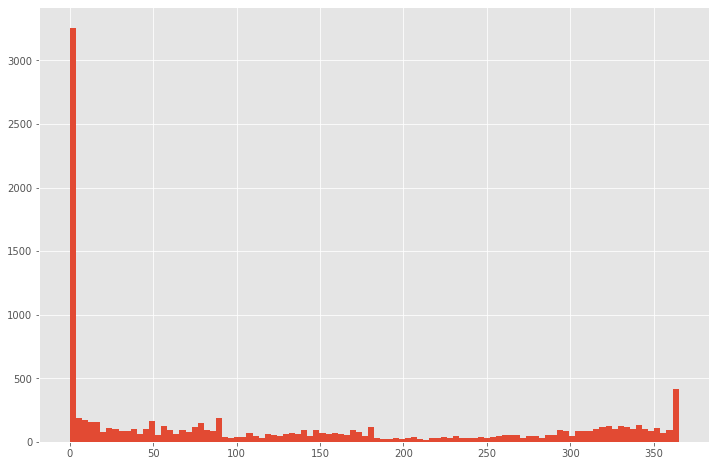

In [88]:
col_info('availability_365')
df.availability_365.hist(bins=100)

In [89]:
#keeping availability for 90 days out and dropping the rest
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

**number_of_reviews**

In [90]:
col_info('number_of_reviews')

Column Name
number_of_reviews

Data Type: int64
Number of Unique Values: 371
Missing Data: 0.0%

Value Counts
0      2224
1       930
2       633
3       471
4       348
       ... 
522       1
490       1
442       1
426       1
443       1
Name: number_of_reviews, Length: 371, dtype: int64


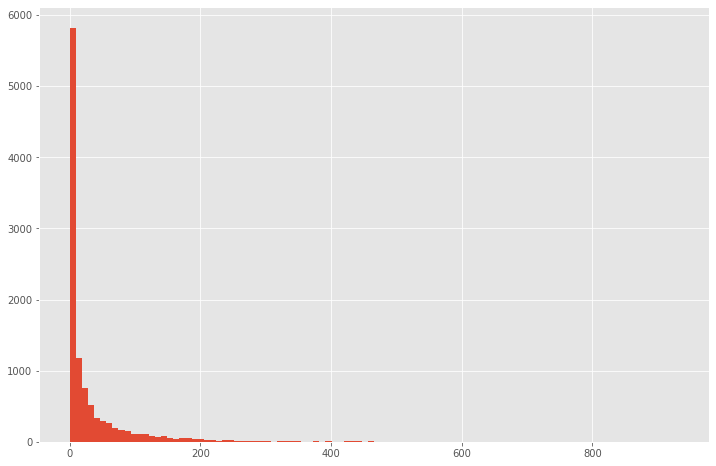

In [91]:
# total number of reviews 
df.number_of_reviews.hist(bins=100)

**number_of_reviews_ltm**

Column Name
number_of_reviews_ltm

Data Type: int64
Number of Unique Values: 142
Missing Data: 0.0%

Value Counts
0      3959
1       765
2       561
3       432
4       327
       ... 
394       1
386       1
122       1
137       1
631       1
Name: number_of_reviews_ltm, Length: 142, dtype: int64


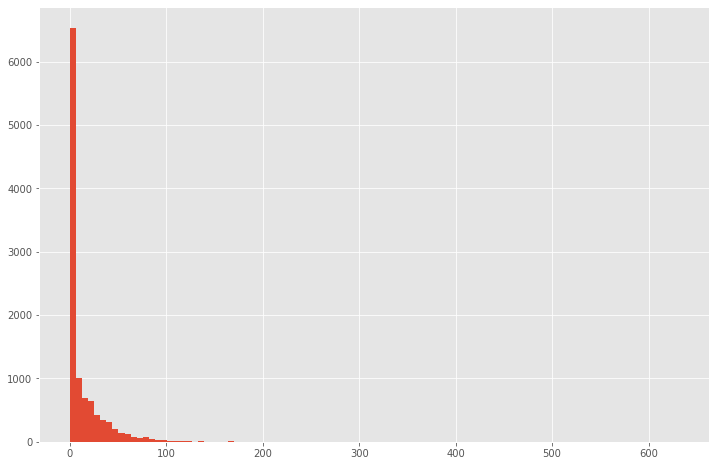

In [92]:
# number of reviews in the last 12 months
col_info('number_of_reviews_ltm')
df.number_of_reviews_ltm.hist(bins=100)

**first_review**

In [93]:
col_info('first_review')

Column Name
first_review

Data Type: object
Number of Unique Values: 1902
Missing Data: 21.0%

Value Counts
NaN           2224
2018-03-11      60
2019-03-10      59
2019-10-06      59
2018-03-13      56
              ... 
2014-09-05       1
2012-05-12       1
2013-05-14       1
2013-01-02       1
2012-03-03       1
Name: first_review, Length: 1903, dtype: int64


This shows that 21% of the listings haven't had their first review yet. This is a large poriton of the data, so I will keep the missing values as is for now.

In [94]:
#Creating a new column that shows the time in number of days since a listings first review
df.first_review = pd.to_datetime(df.first_review)
df['days_since_first_review'] = (dt(2020, 2, 19) - df.first_review)

In [95]:
col_info('days_since_first_review')

Column Name
days_since_first_review

Data Type: timedelta64[ns]
Number of Unique Values: 1902
Missing Data: 21.0%

Value Counts
NaT          2224
710 days       60
136 days       59
346 days       59
708 days       56
             ... 
2576 days       1
2313 days       1
1900 days       1
615 days        1
1351 days       1
Name: days_since_first_review, Length: 1903, dtype: int64


In [96]:
#Converting timedelta to 'Days'
df['days_since_first_review'] = df['days_since_first_review'].astype('timedelta64[D]')

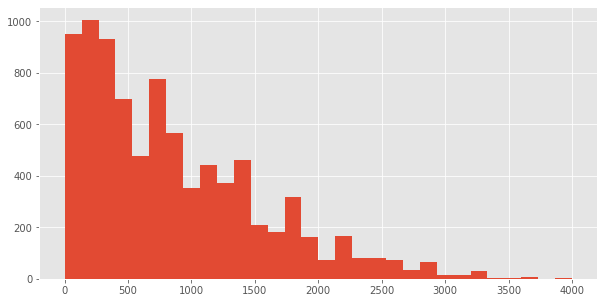

In [97]:
#Histogram showing distributions of the time since first review column
df.days_since_first_review.hist(figsize=(10,5), bins=30);

In [98]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [99]:
# Binning days since first review
bin_column('days_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.days_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

**last_review**

In [100]:
col_info('last_review')

Column Name
last_review

Data Type: object
Number of Unique Values: 1002
Missing Data: 21.0%

Value Counts
NaN           2224
2020-02-16     511
2020-02-17     383
2020-02-09     380
2020-02-02     323
              ... 
2016-07-31       1
2015-03-24       1
2017-05-19       1
2016-04-23       1
2015-08-17       1
Name: last_review, Length: 1003, dtype: int64


In [101]:
#Creating a new column that shows the time in number of days since a listings last review
df.last_review = pd.to_datetime(df.last_review)
df['days_since_last_review'] = (dt(2020, 2, 19) - df.last_review)

In [102]:
#Converting timedelta to 'Days'
df['days_since_last_review'] = df['days_since_last_review'].astype('timedelta64[D]')

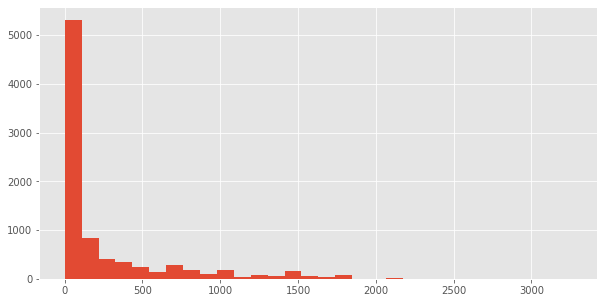

In [103]:
#Histogram showing distributions of the time since first review column
df.days_since_last_review.hist(figsize=(10,5), bins=30);

binning days since last review column

In [104]:
# Binning time since last review
bin_column('days_since_last_review',
           bins=[0, 182, 365, 730, 1460, max(df.days_since_last_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [105]:
#renaming days_since_first_reivew and days_since_last_reivew
df.rename(columns = {'days_since_first_review' : 'time_since_first_review',
                     'days_since_last_review' : 'time_since_last_review'}, inplace=True)

In [106]:
#checking newly binned cols
col_info('time_since_first_review')
col_info('time_since_last_review')

Column Name
time_since_first_review

Data Type: object
Number of Unique Values: 6
Missing Data: 0.0%

Value Counts
2-3 years      2388
nan            2224
1-2 years      1903
4+ years       1554
0-6 months     1477
6-12 months    1234
Name: time_since_first_review, dtype: int64
Column Name
time_since_last_review

Data Type: object
Number of Unique Values: 6
Missing Data: 0.0%

Value Counts
0-6 months     5987
nan            2224
6-12 months     834
2-3 years       774
1-2 years       746
4+ years        215
Name: time_since_last_review, dtype: int64


**review scores**

- Since there are several columns that depict a different variety of review scores, I will write a function to bin all of them.

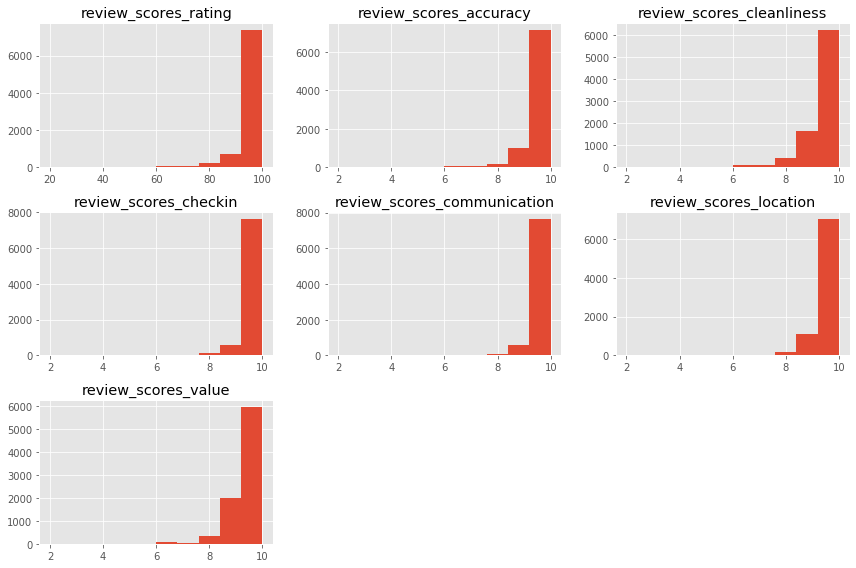

In [107]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [108]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [109]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8', '9', '10'],
               na_label='no reviews')

In [110]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79', '80-94', '95-100'],
           na_label='no reviews')

In [111]:
col_info('review_scores_rating')

Column Name
review_scores_rating

Data Type: object
Number of Unique Values: 4
Missing Data: 0.0%

Value Counts
95-100    6238
nan       2331
80-94     1874
0-79       337
Name: review_scores_rating, dtype: int64


In [112]:
df.extra_people.unique()

array([ 30,  35,  45,   0,  25,   5,  10,  38, 100,  20,  50,  15,  75,
        28,   7,  70,  18, 150,  55,  12,  95,  14,  65,  85,  90,  40,
        60, 125,  11,  29, 300,  89,   8, 200,  80,  33,  34,  61,  69,
       129,  23,  36,  59,  49,  99,  52,  58,   9, 120, 180,  57,  22,
        79,  19, 250,  39,  42,  17,  24,  26,  68,  27, 110,  16,  13,
        41,  56,  37,  32,   6,  98], dtype=int64)

In [113]:
df.host_response_rate.unique()

array(['100%', 'unknown', '50-89%', '0-49%', '90-99%'], dtype=object)

In [114]:
df.host_acceptance_rate.unique()

array(['100%', '98%', '93%', '83%', '61%', '69%', '50%', nan, '91%',
       '94%', '43%', '85%', '96%', '84%', '77%', '33%', '78%', '90%',
       '99%', '97%', '67%', '82%', '79%', '0%', '95%', '92%', '46%',
       '89%', '57%', '80%', '52%', '86%', '17%', '68%', '76%', '88%',
       '75%', '87%', '66%', '62%', '30%', '63%', '35%', '58%', '71%',
       '70%', '81%', '25%', '36%', '60%', '64%', '74%', '20%', '44%',
       '73%', '54%', '32%', '40%', '14%', '55%', '27%', '48%', '42%',
       '29%', '56%', '22%', '59%', '49%', '38%', '72%', '13%', '51%',
       '41%', '45%', '65%', '37%', '9%', '47%', '53%', '15%', '39%', '6%',
       '21%', '19%', '26%'], dtype=object)

In [115]:
col_info('reviews_per_month')

Column Name
reviews_per_month

Data Type: float64
Number of Unique Values: 818
Missing Data: 0.0%

Value Counts
0.00    2224
0.02     191
0.04     181
0.08     150
0.03     130
        ... 
6.49       1
7.93       1
7.65       1
7.98       1
9.46       1
Name: reviews_per_month, Length: 818, dtype: int64


In [116]:
drop_cols = ['host_acceptance_rate', 'city', 'jurisdiction_names', 'require_guest_profile_picture']
df.drop(drop_cols, axis=1, inplace=True)

In [117]:
#writing a copy of the cleaned dataframe to a csv file
df.to_csv(r'listings_cleaned.csv')

# EDA

1. Which areas/neighborhoods in Austin, TX are the most expensive and have the
most listings?
2. What are the most common listing types? (ie: entire home/apartment or shared
space?)
3. How long have different hosts been listing properties through Airbnb and how
many listings do host’s have on average?
4. How do Airbnb prices correlate with the number of people a listing
accommodates?
5. How favorable are reviews and what do the distributions look like?
6. What are the most common amenities, and which amenities are likely to increase
the price of a listing?
7. What is the value of being a superhost? Is it worth getting verified?

_**1. Which areas/neighborhoods in Austin, TX are the most expensive and have the most listings?**_

In [118]:
# Importing the Austin borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df = map_df.drop('neighbourhood_group', axis=1)
map_df = map_df.rename(columns = {'neighbourhood': 'zip_code'})
map_df['zip_code'] = map_df['zip_code'].astype('int64')
map_df = map_df.set_index('zip_code')

In [119]:
# Creating a dataframe of listing counts and median price by zip_code
df = df.rename(columns={'neighbourhood_cleansed' : 'zip_code'})
zip_df = pd.DataFrame(df.groupby('zip_code').size())
zip_df.rename(columns={0: 'number_of_listings'}, inplace=True)
zip_df['median_price'] = df.groupby('zip_code').price.median().values

# Joining the dataframes
zip_map_df = map_df.join(zip_df)

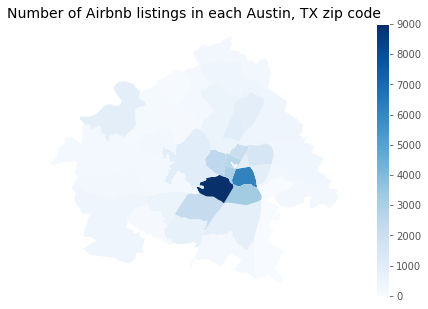

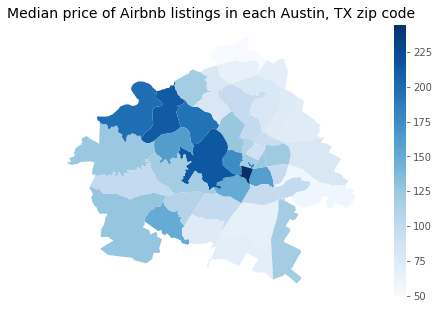

In [120]:
# Plotting the number of listings in each zip code
fig1, ax1 = plt.subplots(1, figsize=(8, 5))
zip_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each zip code
fig2, ax2 = plt.subplots(1, figsize=(8, 5))
zip_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(zip_map_df.median_price), vmax=max(zip_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

_**2. What are the most common listing types? (ie: entire home/apartment or shared space?)**_

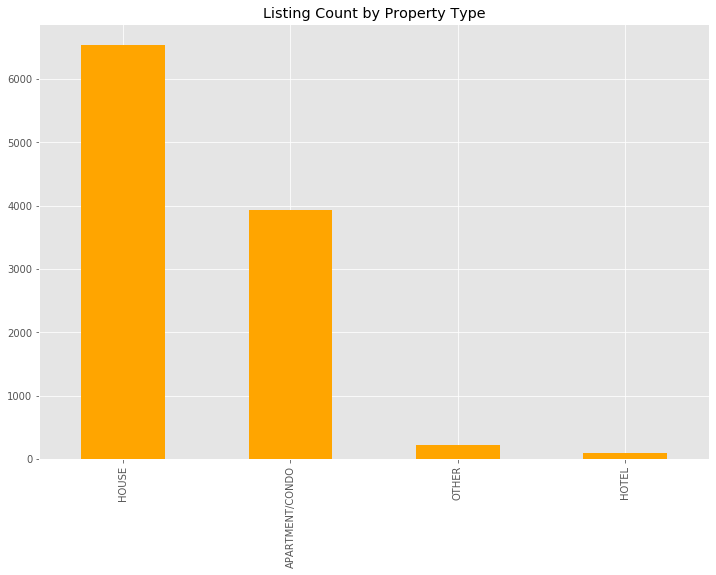

In [121]:
plt.title("Listing Count by Property Type")
df.property_type.value_counts().plot(kind='bar', color = 'orange')

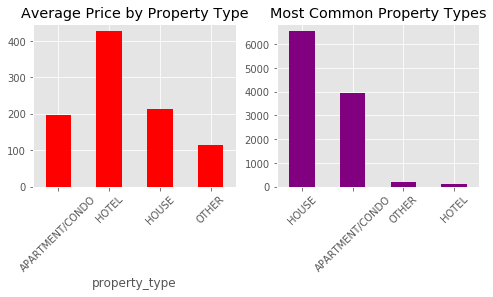

In [122]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
df.groupby('property_type').price.mean().plot(kind='bar', color = 'red', ax=ax1)
ax1.set_title("Average Price by Property Type")
ax1.tick_params(axis='x', labelrotation=45)
df.property_type.value_counts().plot(kind='bar', color = 'purple', ax=ax2)
ax2.set_title("Most Common Property Types")
ax2.tick_params(axis='x', labelrotation=45)

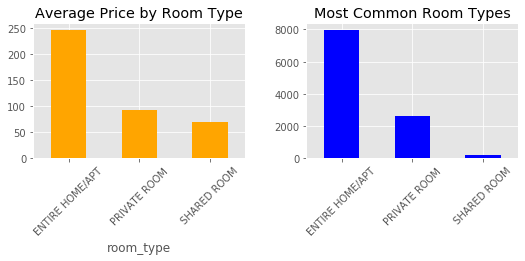

In [123]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout(pad=3)
df.groupby('room_type').price.mean().plot(kind='bar', color = 'orange', ax=ax1)
ax1.set_title("Average Price by Room Type")
ax1.tick_params(axis='x', labelrotation=45)
df.room_type.value_counts().plot(kind='bar', color = 'blue', ax=ax2)
ax2.set_title("Most Common Room Types")
ax2.tick_params(axis='x', labelrotation=45)

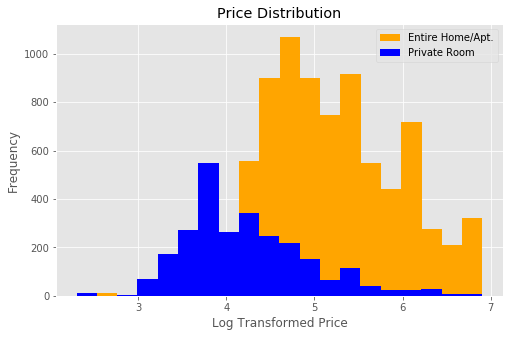

In [124]:
_ = plt.style.use('ggplot')
_ = plt.figure(figsize=(8,5))
_ = plt.title('Price Distribution')
_ = np.log(df[df['room_type']== 'ENTIRE HOME/APT'].price).plot(kind='hist', color = 'orange', bins=20)
_ = np.log(df[df['room_type']== 'PRIVATE ROOM'].price).plot(kind='hist', color = 'blue', bins=20)
_ = plt.xlabel("Log Transformed Price")
_ = plt.legend(('Entire Home/Apt.', 'Private Room'), loc='upper right')

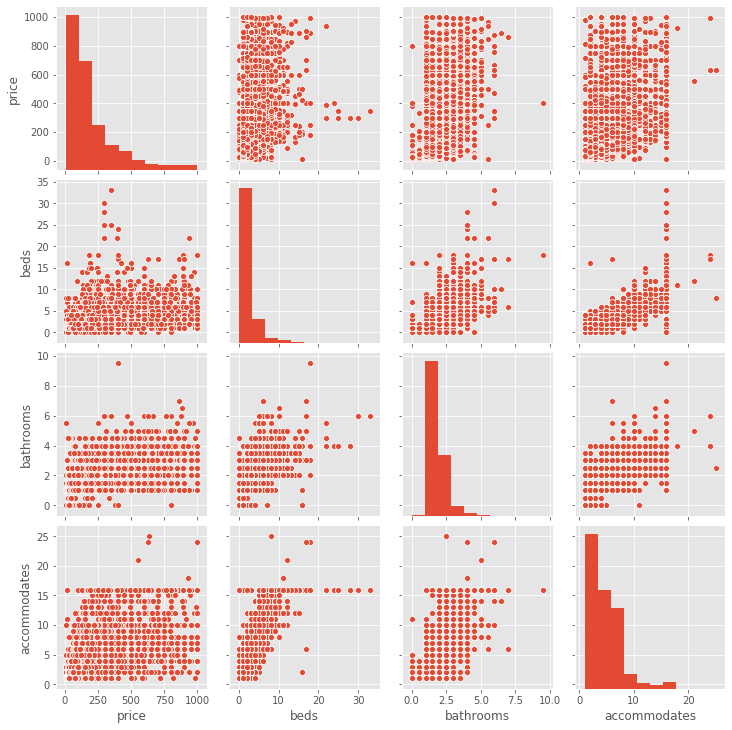

In [125]:
pairplt_features = ['price', 'beds', 'bathrooms', 'accommodates']
pairplt_df = df[pairplt_features]
sns.pairplot(pairplt_df)

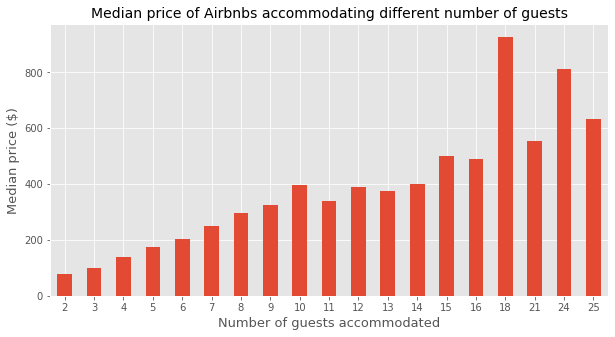

In [126]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

_**3. How long have different hosts been listing properties through Airbnb and how many listings do host’s have on average?**_

In [127]:
# Converting to datetime object
df['host_since'] = pd.to_datetime(df['host_since'])
# Calcuating the number of days a host has been active on Airbnb
# I used 2/19/2020 as the end date since that was the date this data was scraped
df['days_as_host'] = (dt(2020, 2, 19) - df.host_since).astype('timedelta64[D]')

#Creating a new column that shows the time in number of days since a listings first review
df.first_review = pd.to_datetime(df.first_review)
df['days_since_first_review'] = (dt(2020, 2, 19) - df.first_review)

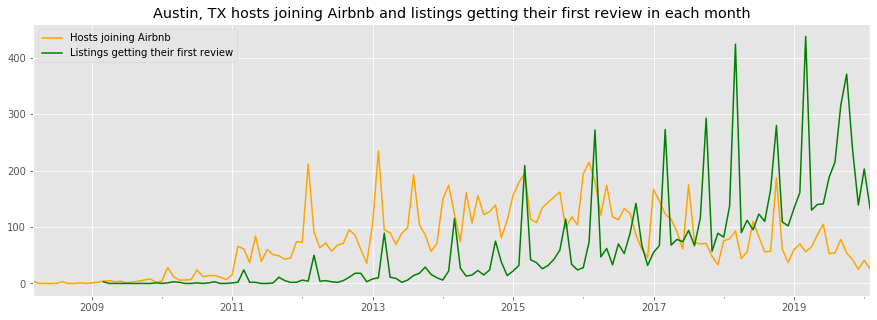

In [128]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('M').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('M').size().plot(label='Listings getting their first review', color='green')
plt.title('Austin, TX hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-03-08', '2020-02-19')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [129]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [130]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

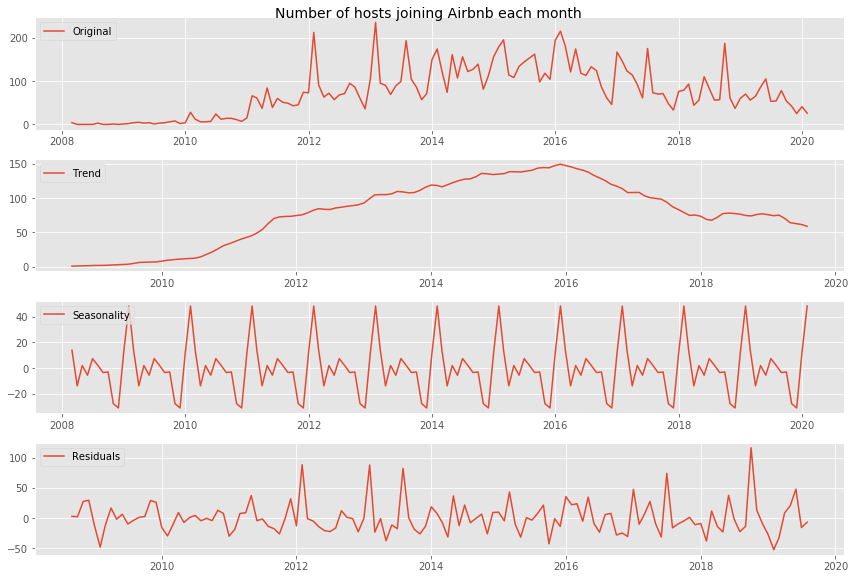

In [131]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

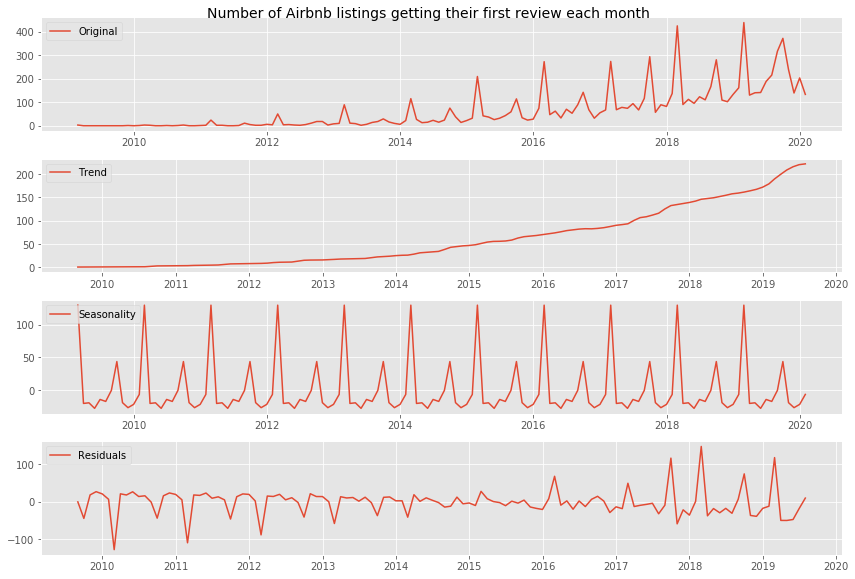

In [132]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

_**4. How do Airbnb prices correlate with the number of people a listing
accommodates?**_

In [133]:
df['accommodates'].corr(df['price'])

0.5092726180991967

Text(0, 0.5, 'Price $')

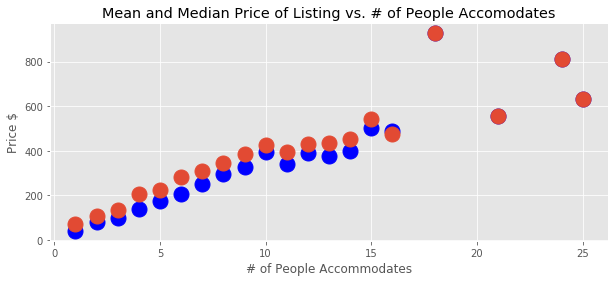

In [134]:
pivot_price_mean = pd.pivot_table(df, values='price', index='accommodates', aggfunc='median')
pivot_price_median = pd.pivot_table(df, values='price' , index='accommodates')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
# plt.title("Mean and Median Price of Listing vs. # of People Accomodates")
# plt.plot(pivot_price_mean, linestyle='none', marker='.', markersize=30, color='b', ax=ax1)
# ax1.set_title("Mean Price of Listing vs. # Accommodates")
# plt.plot(pivot_price_median, linestyle='none', marker='.', markersize=30, ax=ax2)
# ax2.set_title("Median Price of Listing vs. # Accommodates")

plt.figure(figsize=(10,4))
plt.title("Mean and Median Price of Listing vs. # of People Accomodates")
pivot_price_mean = pd.pivot_table(df, values='price', index='accommodates', aggfunc='median')
plt.plot(pivot_price_mean, linestyle='none', marker='.', markersize=30, color='b')
pivot_price_median = pd.pivot_table(df, values='price' , index='accommodates')
plt.plot(pivot_price_median, linestyle='none', marker='.', markersize=30)
plt.xlabel('# of People Accommodates')
plt.ylabel('Price $')
# plt.legend()

_**5. How favorable are reviews and what do the distributions look like?**_

In [135]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

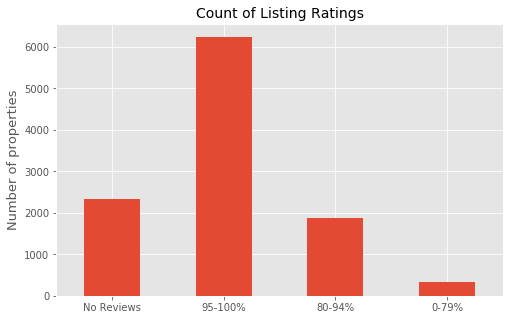

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Count of Listing Ratings', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', ax=ax)
ax.set_ylabel('Number of properties', fontsize=13)
ax.set_xticklabels(labels=['No Reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
plt.show()

It is clear that in general, people give high review scores.

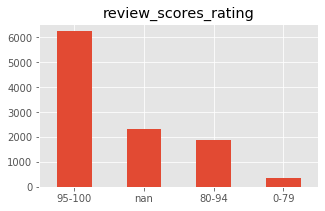

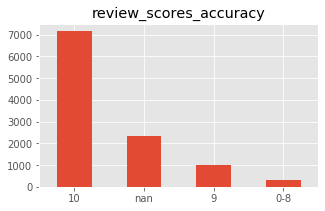

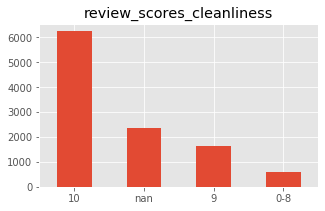

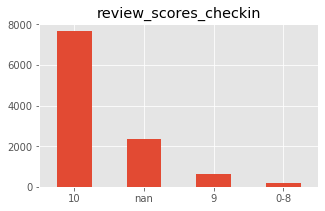

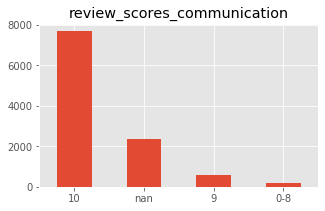

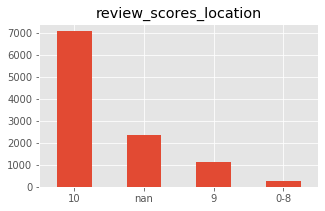

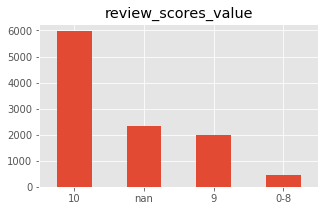

In [137]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

_**6. What are the most common amenities, and which amenities are likely to increase**_

In [138]:
df.columns.get_loc("check_in_24h")

38

In [139]:
df.columns.get_loc("event_suitable")

60

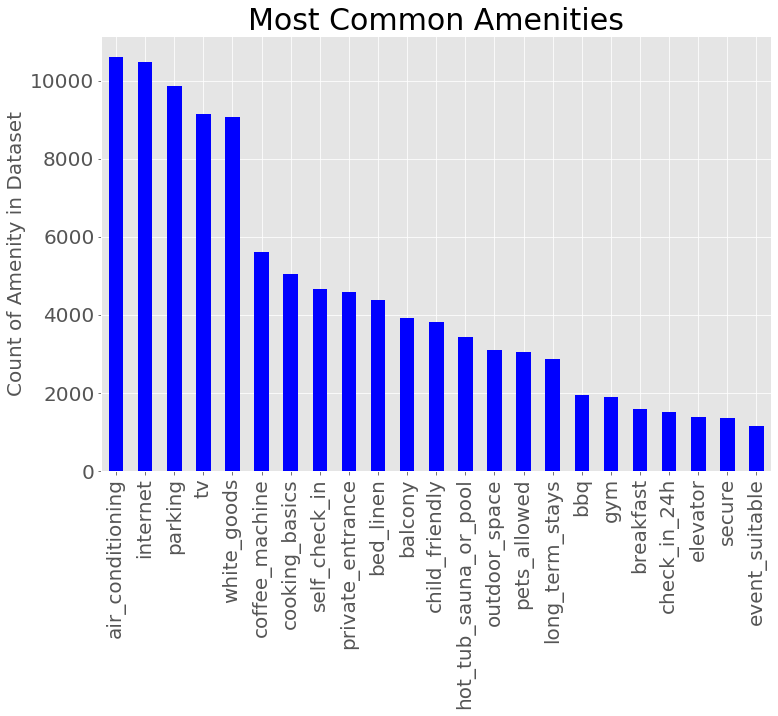

In [140]:
plt.title('Most Common Amenities', size=30)
plt.ylabel('Count of Amenity in Dataset', size=20)
ax = df.iloc[:,38:61].sum().sort_values(ascending=False).plot(kind='bar', color ='b')
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

In [141]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.75) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count', size=10)
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)', size=10)
    ax2.set_xlabel('')
    
    plt.show()

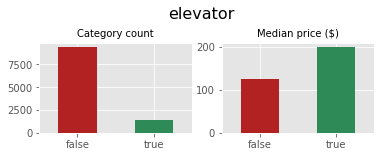

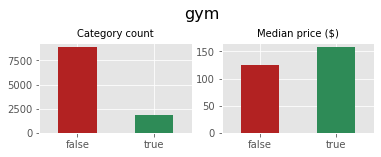

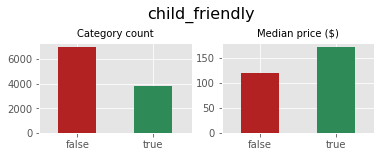

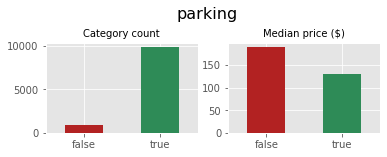

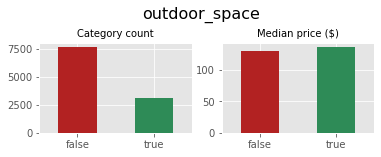

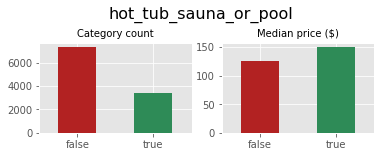

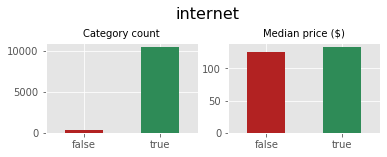

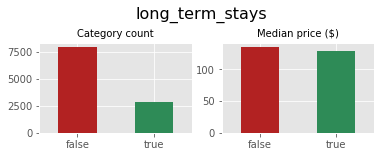

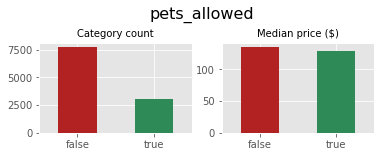

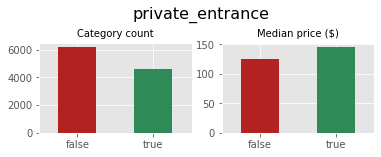

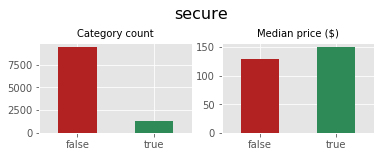

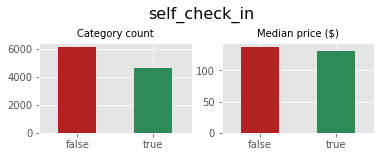

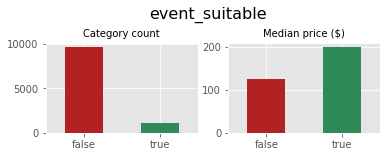

In [142]:
for col in df.iloc[:,48:61].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

In [143]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x =  np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

In [144]:
def ecdf_plot_generator(col):
    """Plots ECDF for a binary column in a dataframe"""
    plt.style.use('ggplot')

    # Selecting x,y data from the dataframe ('df')
    true = np.array(df[df[col] == 1].price)
    false = np.array(df[df[col] == 0].price)

    # Compute x,y values for ECDFs
    x_true, y_true = ecdf(true)
    x_false, y_false = ecdf(false)

    # Plot the ECDFs
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(x_true, y_true, marker='.', linestyle='none')
    _ = plt.plot(x_false, y_false, marker='.', linestyle='none')

    # Set the margins
    _ = plt.margins(0.02)

    # Add a legend
    _ = plt.legend(('Yes', 'No'), loc='lower right')

    # Label axes and show plot
    _ = plt.xlabel('Price of Listing $')
    _ = plt.ylabel('ECDF Probability %')
    _ = plt.title(col)
    _ = plt.show()

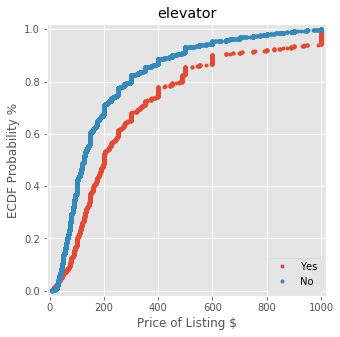

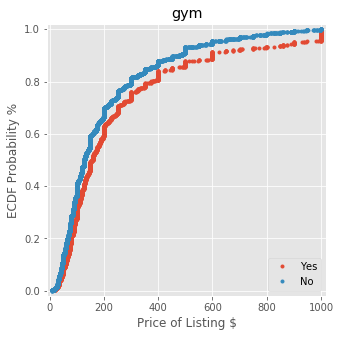

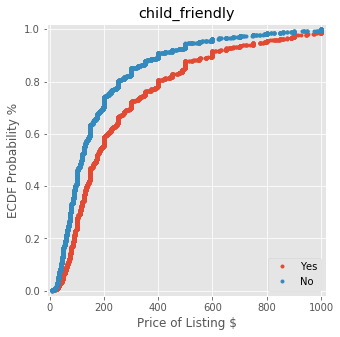

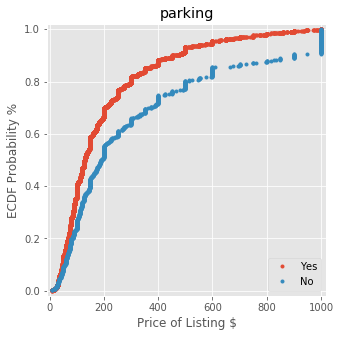

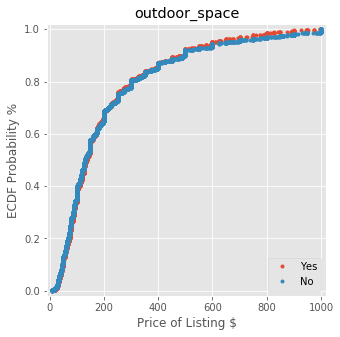

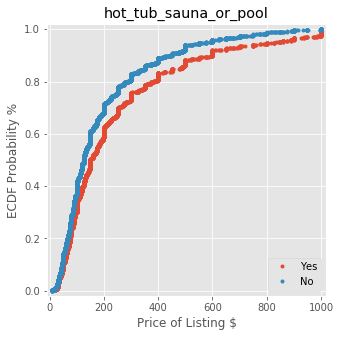

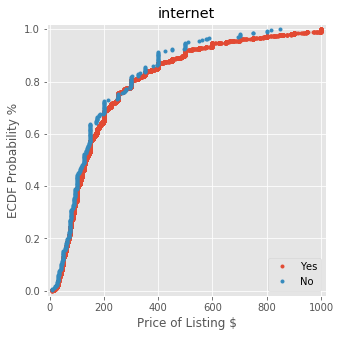

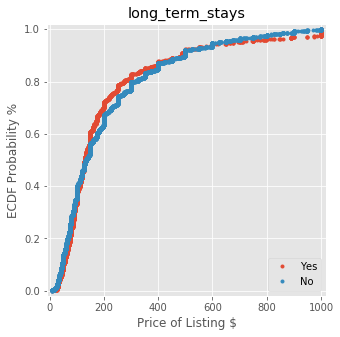

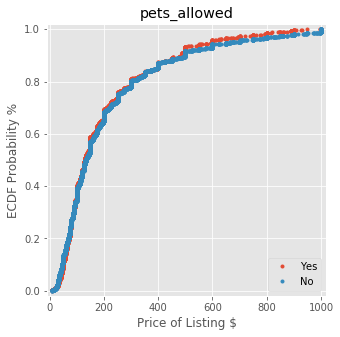

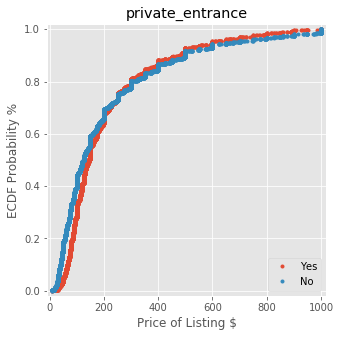

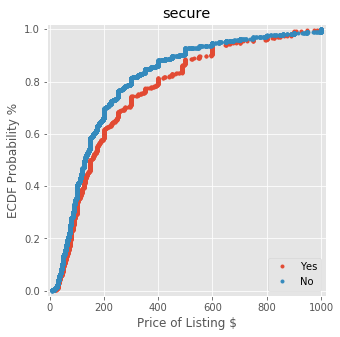

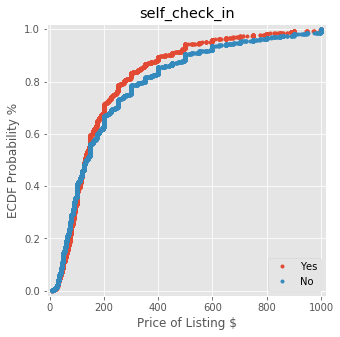

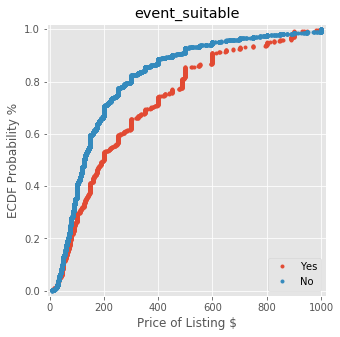

In [145]:
for col in df.iloc[:,48:61].columns:
    ecdf_plot_generator(col)

_**7. What is the value of being a superhost? Is it worth getting verified?**_

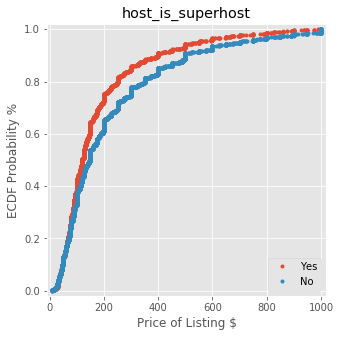

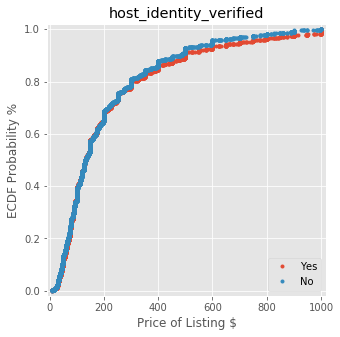

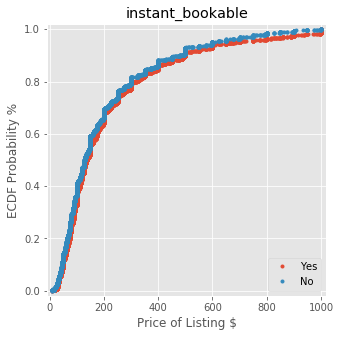

In [146]:
for i in list(['host_is_superhost', 'host_identity_verified', 'instant_bookable']):
    ecdf_plot_generator(i)

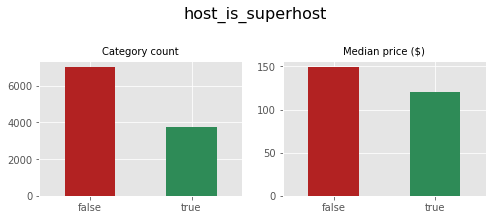

0.0    0.650956
1.0    0.349044
Name: host_is_superhost, dtype: float64


In [147]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

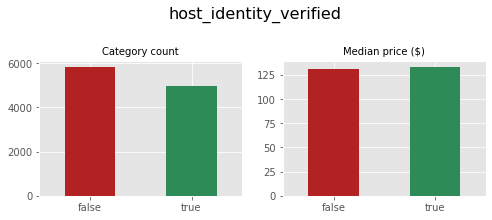

0.0    0.539618
1.0    0.460382
Name: host_identity_verified, dtype: float64


In [148]:
binary_count_and_price_plot('host_identity_verified')
print(df.host_identity_verified.value_counts(normalize=True))

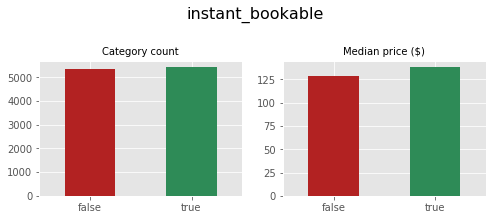

1    0.502597
0    0.497403
Name: instant_bookable, dtype: float64


In [149]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

# Machine Learning Algorithims

## Model Preparation

One hot-encoding categorical variables

In [150]:
df.dropna(inplace=True)

#dropping columns not useful for model
drop_cols = ['days_since_first_review', 'first_review', 'last_review', 'host_since', 'zip_code']
df.drop(drop_cols, axis=1, inplace=True)

In [151]:
encoded_df = pd.get_dummies(df)
encoded_df.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,require_guest_phone_verification,reviews_per_month,days_as_host,check_in_24h,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,event_suitable,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,...,property_type_OTHER,room_type_ENTIRE HOME/APT,room_type_PRIVATE ROOM,room_type_SHARED ROOM,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,review_scores_rating_0-79,review_scores_rating_80-94,review_scores_rating_95-100,review_scores_rating_nan,review_scores_accuracy_0-8,review_scores_accuracy_10,review_scores_accuracy_9,review_scores_accuracy_nan,review_scores_cleanliness_0-8,review_scores_cleanliness_10,review_scores_cleanliness_9,review_scores_cleanliness_nan,review_scores_checkin_0-8,review_scores_checkin_10,review_scores_checkin_9,review_scores_checkin_nan,review_scores_communication_0-8,review_scores_communication_10,review_scores_communication_9,review_scores_communication_nan,review_scores_location_0-8,review_scores_location_10,review_scores_location_9,review_scores_location_nan,review_scores_value_0-8,review_scores_value_10,review_scores_value_9,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-6 months,time_since_last_review_1-2 years,time_since_last_review_2-3 years,time_since_last_review_4+ years,time_since_last_review_6-12 months
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2265,1.0,1.0,4,2.0,2.0,2.0,225,500,100,4,30,30,90,0,24,1,0,0,0.18,4197.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
5245,1.0,1.0,2,1.0,1.0,2.0,100,500,75,2,35,30,60,0,9,0,0,0,0.07,4197.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
5456,1.0,1.0,3,1.0,1.0,2.0,95,100,0,2,45,2,90,54,522,51,0,1,3.91,4020.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
5769,1.0,1.0,2,1.0,1.0,1.0,40,0,0,2,0,1,14,0,257,18,0,1,2.14,4017.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
6413,1.0,0.0,2,1.0,0.0,1.0,99,0,50,2,25,4,365,18,109,23,0,0,0.88,3960.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


Assessing the data for multi-collinearity using code from seaborn documentation. https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [152]:
def multi_col_heatmap(df, figsize=(15,15)):

    """
    Plots a diagonal matrix correlation heatmap between dataframe features.
    """
    
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=corr[corr != 1.0].max().max(), center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

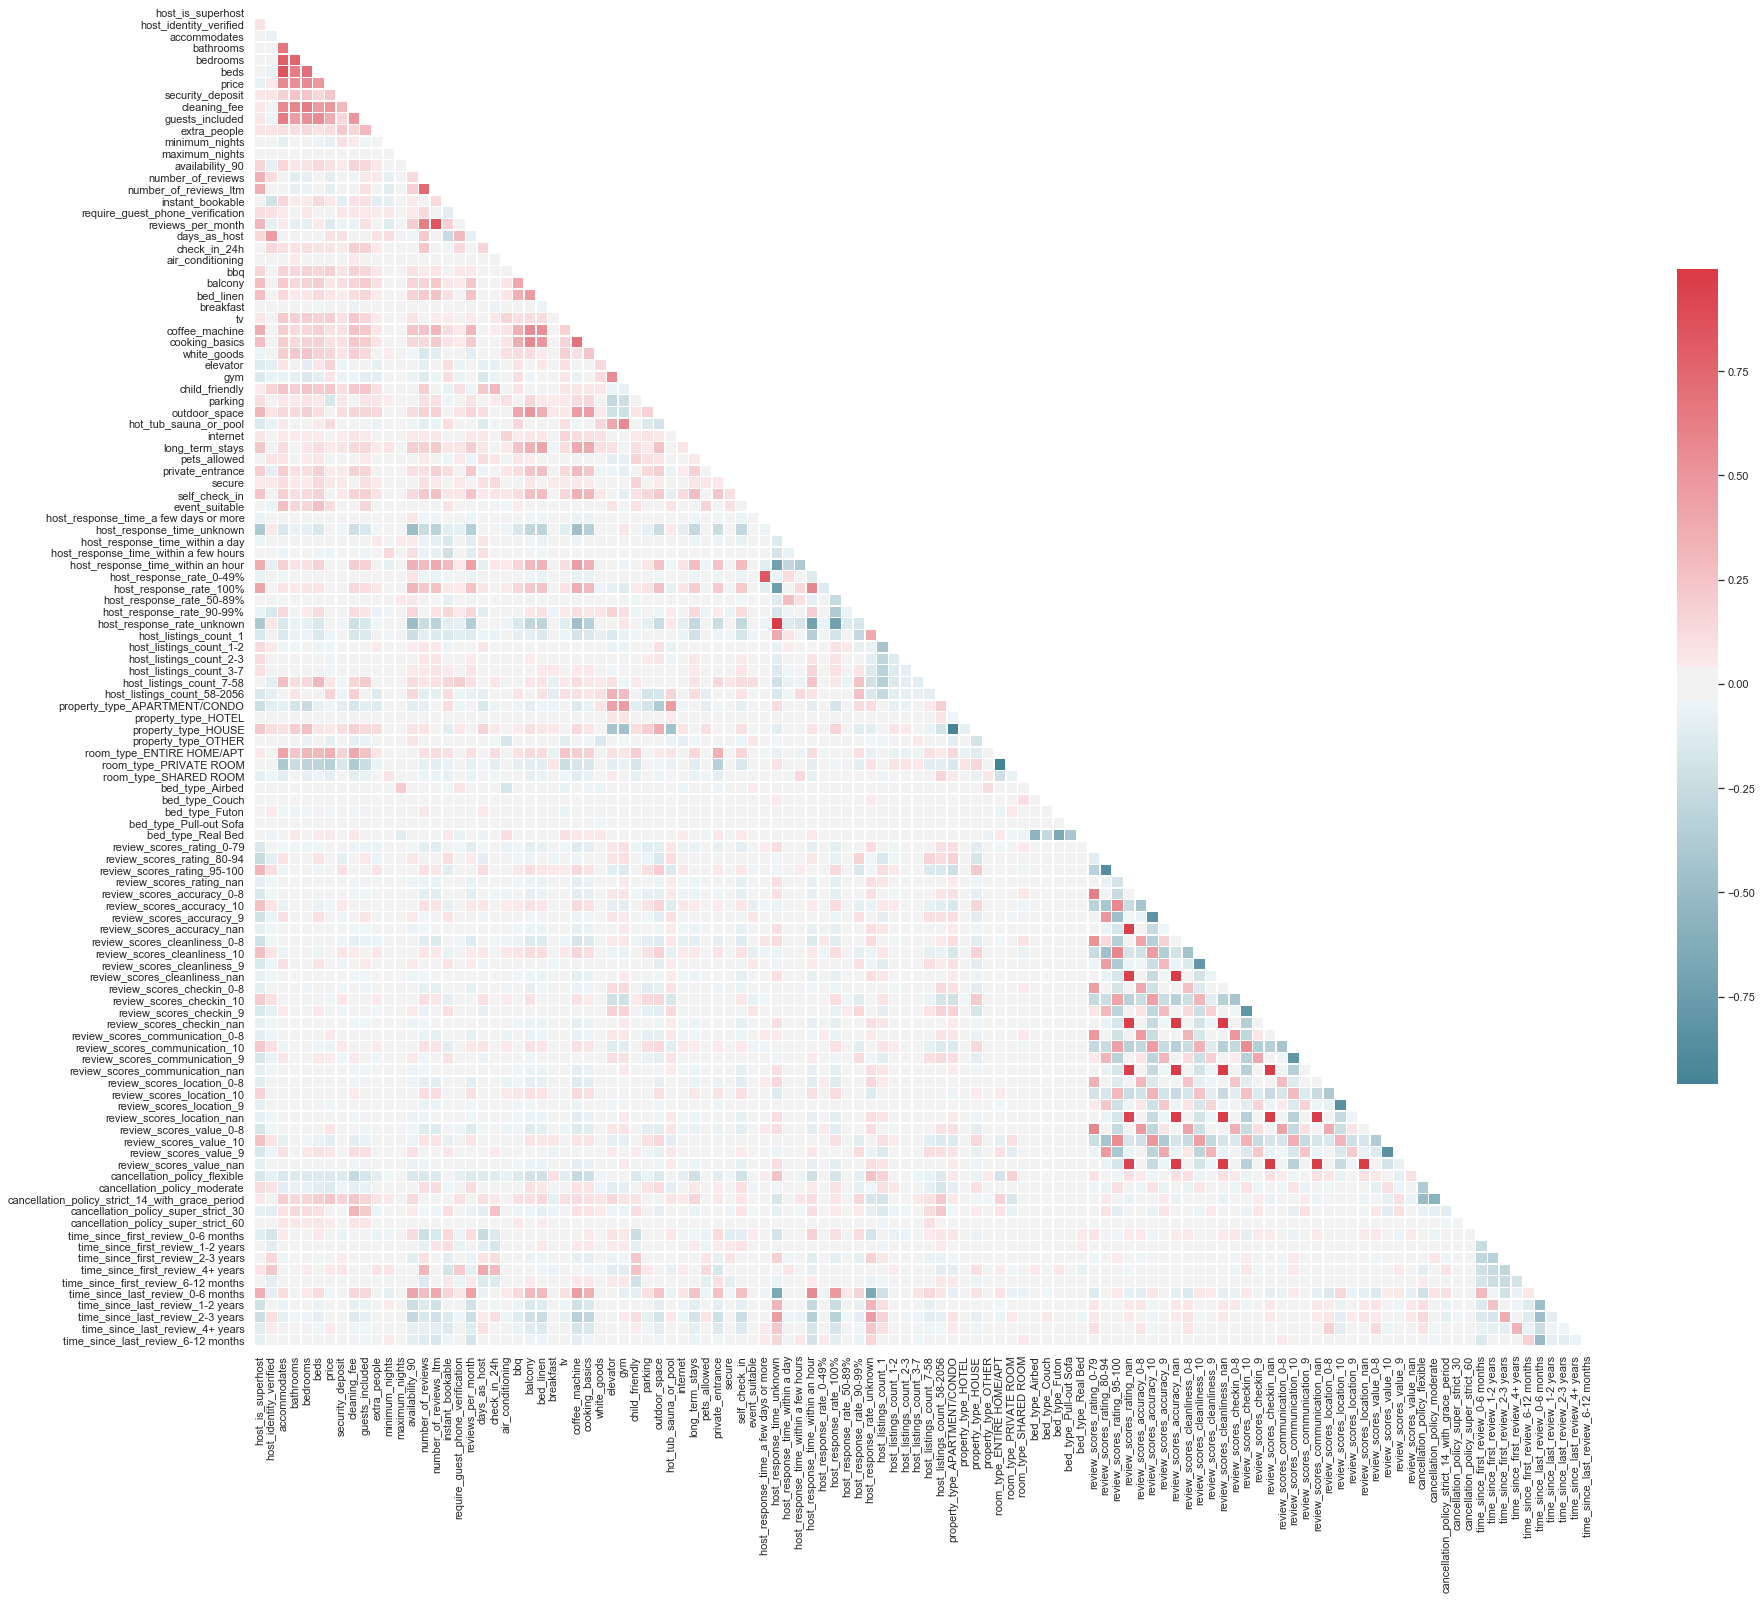

In [153]:
multi_col_heatmap(encoded_df, figsize=(30,30))

There doesn't appear to be any collinear relationships with the bed_type features, therefore it will be dropped.

The beds, bedrooms and guests features are all highly correlated with the number of people that a listing accommodates. Since they are highly correlated, I will remove those features and keep accommodates.


In [154]:
drop_cols = ['beds', 'bedrooms', 'guests_included']
encoded_df.drop(drop_cols, axis=1, inplace=True)

In [155]:
encoded_df.drop(list(encoded_df.columns[encoded_df.columns.str.startswith('bed_type')]), axis=1, inplace=True)

In [156]:
encoded_df.drop(list(encoded_df.columns[encoded_df.columns.str.endswith('nan')]), axis=1, inplace=True)

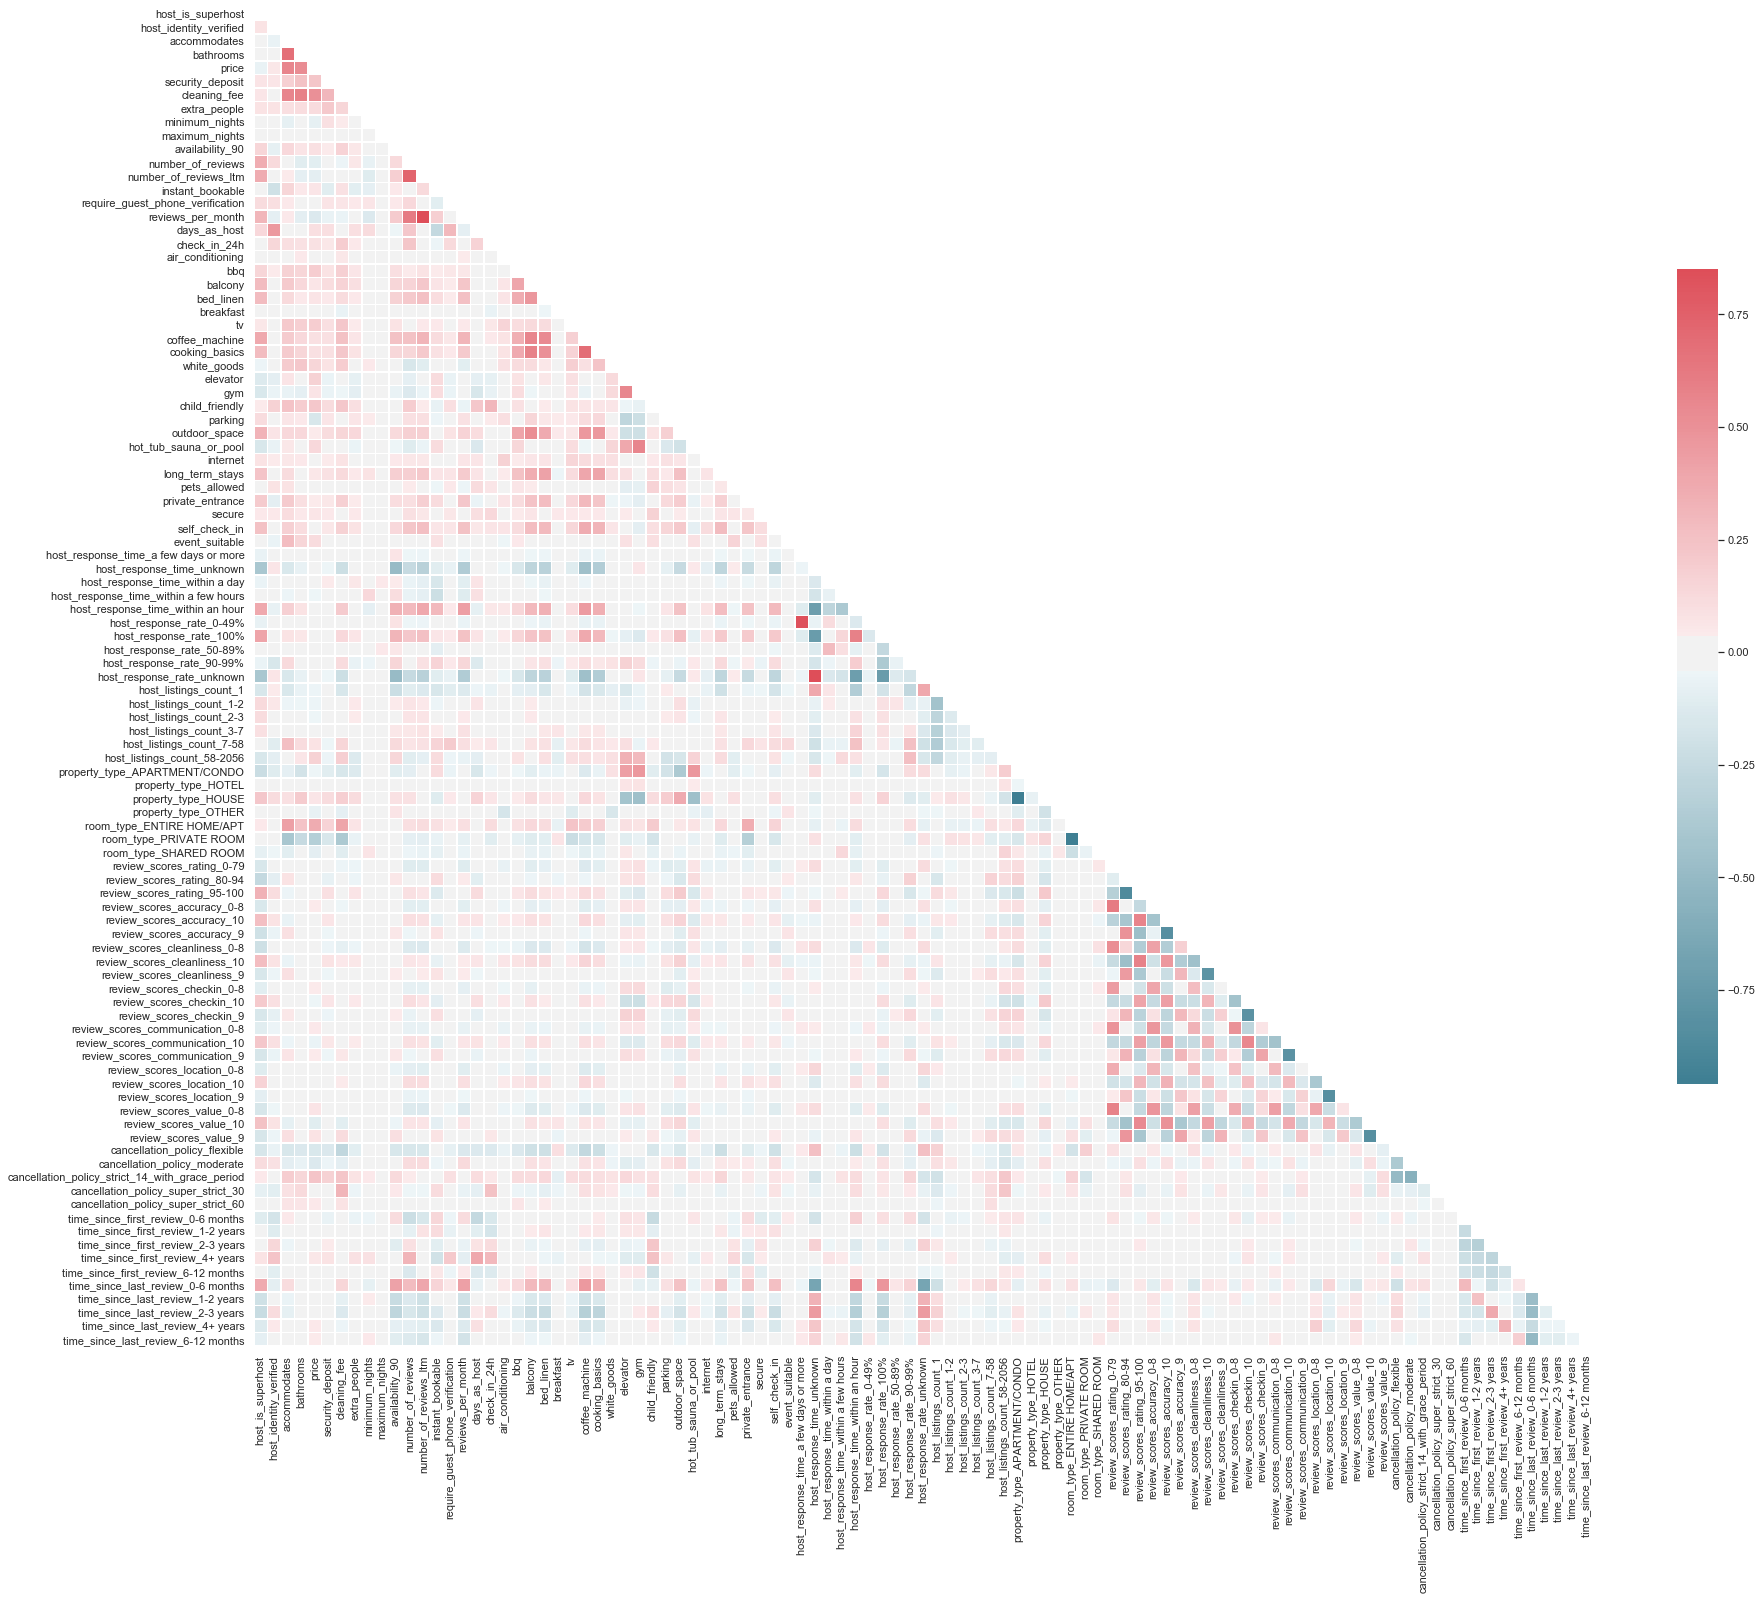

In [157]:
multi_col_heatmap(encoded_df, figsize=(30,30))

## Standardizing the Data

In [158]:
num_features = ['accommodates', 'bathrooms', 'price', 'security_deposit', 
                'cleaning_fee', 'extra_people', 'minimum_nights', 'maximum_nights', 
                'availability_90', 'number_of_reviews', 'days_as_host']

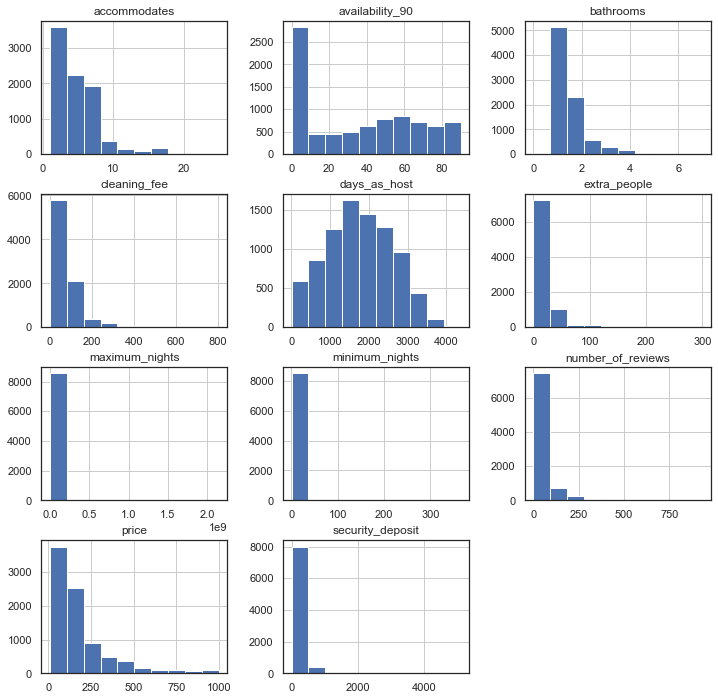

In [159]:
encoded_df[num_features].hist(figsize=(12,12));

In [160]:
log_num_features = ['price','accommodates', 'bathrooms', 'security_deposit', 
                    'cleaning_fee', 'extra_people', 'minimum_nights',
                    'maximum_nights', 'number_of_reviews']

#log transforming columns
for col in log_num_features:
    encoded_df[col] = encoded_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    encoded_df[col] = np.log(encoded_df[col])

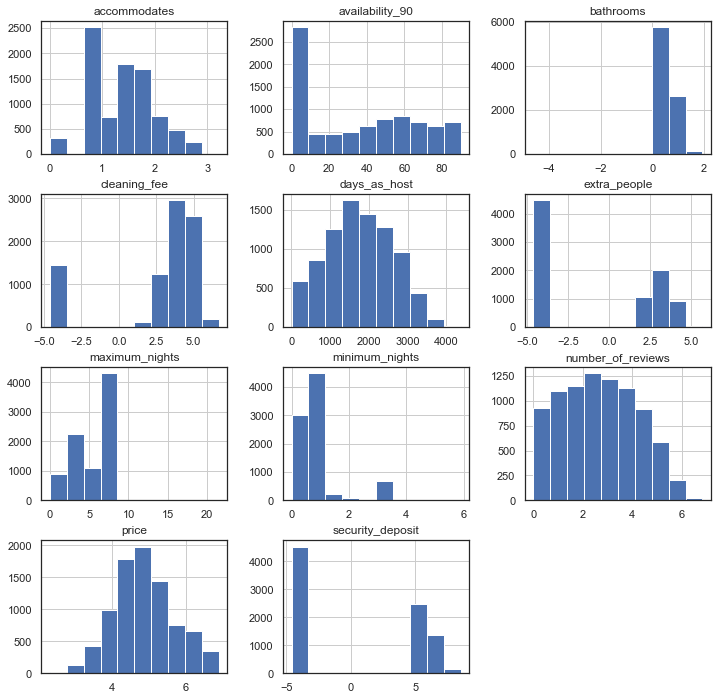

In [161]:
encoded_df[num_features].hist(figsize=(12,12));

In [162]:
encoded_df.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,require_guest_phone_verification,reviews_per_month,days_as_host,check_in_24h,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,event_suitable,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,host_listings_count_1,host_listings_count_1-2,host_listings_count_2-3,host_listings_count_3-7,host_listings_count_7-58,host_listings_count_58-2056,property_type_APARTMENT/CONDO,property_type_HOTEL,property_type_HOUSE,property_type_OTHER,room_type_ENTIRE HOME/APT,room_type_PRIVATE ROOM,room_type_SHARED ROOM,review_scores_rating_0-79,review_scores_rating_80-94,review_scores_rating_95-100,review_scores_accuracy_0-8,review_scores_accuracy_10,review_scores_accuracy_9,review_scores_cleanliness_0-8,review_scores_cleanliness_10,review_scores_cleanliness_9,review_scores_checkin_0-8,review_scores_checkin_10,review_scores_checkin_9,review_scores_communication_0-8,review_scores_communication_10,review_scores_communication_9,review_scores_location_0-8,review_scores_location_10,review_scores_location_9,review_scores_value_0-8,review_scores_value_10,review_scores_value_9,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-6 months,time_since_last_review_1-2 years,time_since_last_review_2-3 years,time_since_last_review_4+ years,time_since_last_review_6-12 months
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2265,1.0,1.0,1.386294,0.693147,5.416100,6.214608,4.605170,3.401197,3.401197,4.499810,0,3.178054,1,0,0,0.18,4197.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
5245,1.0,1.0,0.693147,0.000000,4.605170,6.214608,4.317488,3.555348,3.401197,4.094345,0,2.197225,0,0,0,0.07,4197.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
5456,1.0,1.0,1.098612,0.000000,4.553877,4.605170,-4.605170,3.806662,0.693147,4.499810,54,6.257668,51,0,1,3.91,4020.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
5769,1.0,1.0,0.693147,0.000000,3.688879,-4.605170,-4.605170,-4.605170,0.000000,2.639057,0,5.549076,18,0,1,2.14,4017.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
6413,1.0,0.0,0.693147,0.000000,4.595120,-4.605170,3.912023,3.218876,1.386294,5.899897,18,4.691348,23,0,0,0.88,3960.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


## Model Testing

#### Scaling Data

In [198]:
# Separating the features and target variable
X = encoded_df.drop(['price'], axis=1)
y = encoded_df.price

# Scaling features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

#### Model 1: Regression Model using SKLearn

In [226]:
# Setting up and shuffling the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

lr = LinearRegression()
lr.fit(X_train, y_train)
# y_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

print("Test R^2: {}".format(lr.score(X_test, y_test)))

rmse_test = mean_squared_error(y_test, y_pred)

print("Test MSE: {}".format(rmse_test))

Test R^2: 0.6373646843543308
Test MSE: 0.2504150318627005


#### Model 2: Gradient Boosting Regressing from SKLearn

In [222]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [239]:
gbr_SK_start = time.time()

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

gbr_SK_end = time.time()

mse_train = mean_squared_error(y_train, reg.predict(X_train))
mse_test = mean_squared_error(y_test, reg.predict(X_test))

print(f"Computational Time: {round((gbr_SK_end - gbr_SK_start),1)} seconds")
print("The R^2 value on train set: {:.4f}".format(reg.score(X_train, y_train)))
print("The R^2 value on test set: {:.4f}".format(reg.score(X_test, y_test)))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))

Computational Time: 11.8 seconds
The R^2 value on train set: 0.7274
The R^2 value on test set: 0.6866
The mean squared error (MSE) on train set: 0.1928
The mean squared error (MSE) on test set: 0.2164


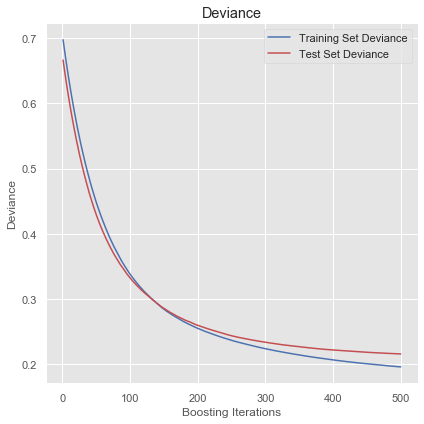

In [224]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

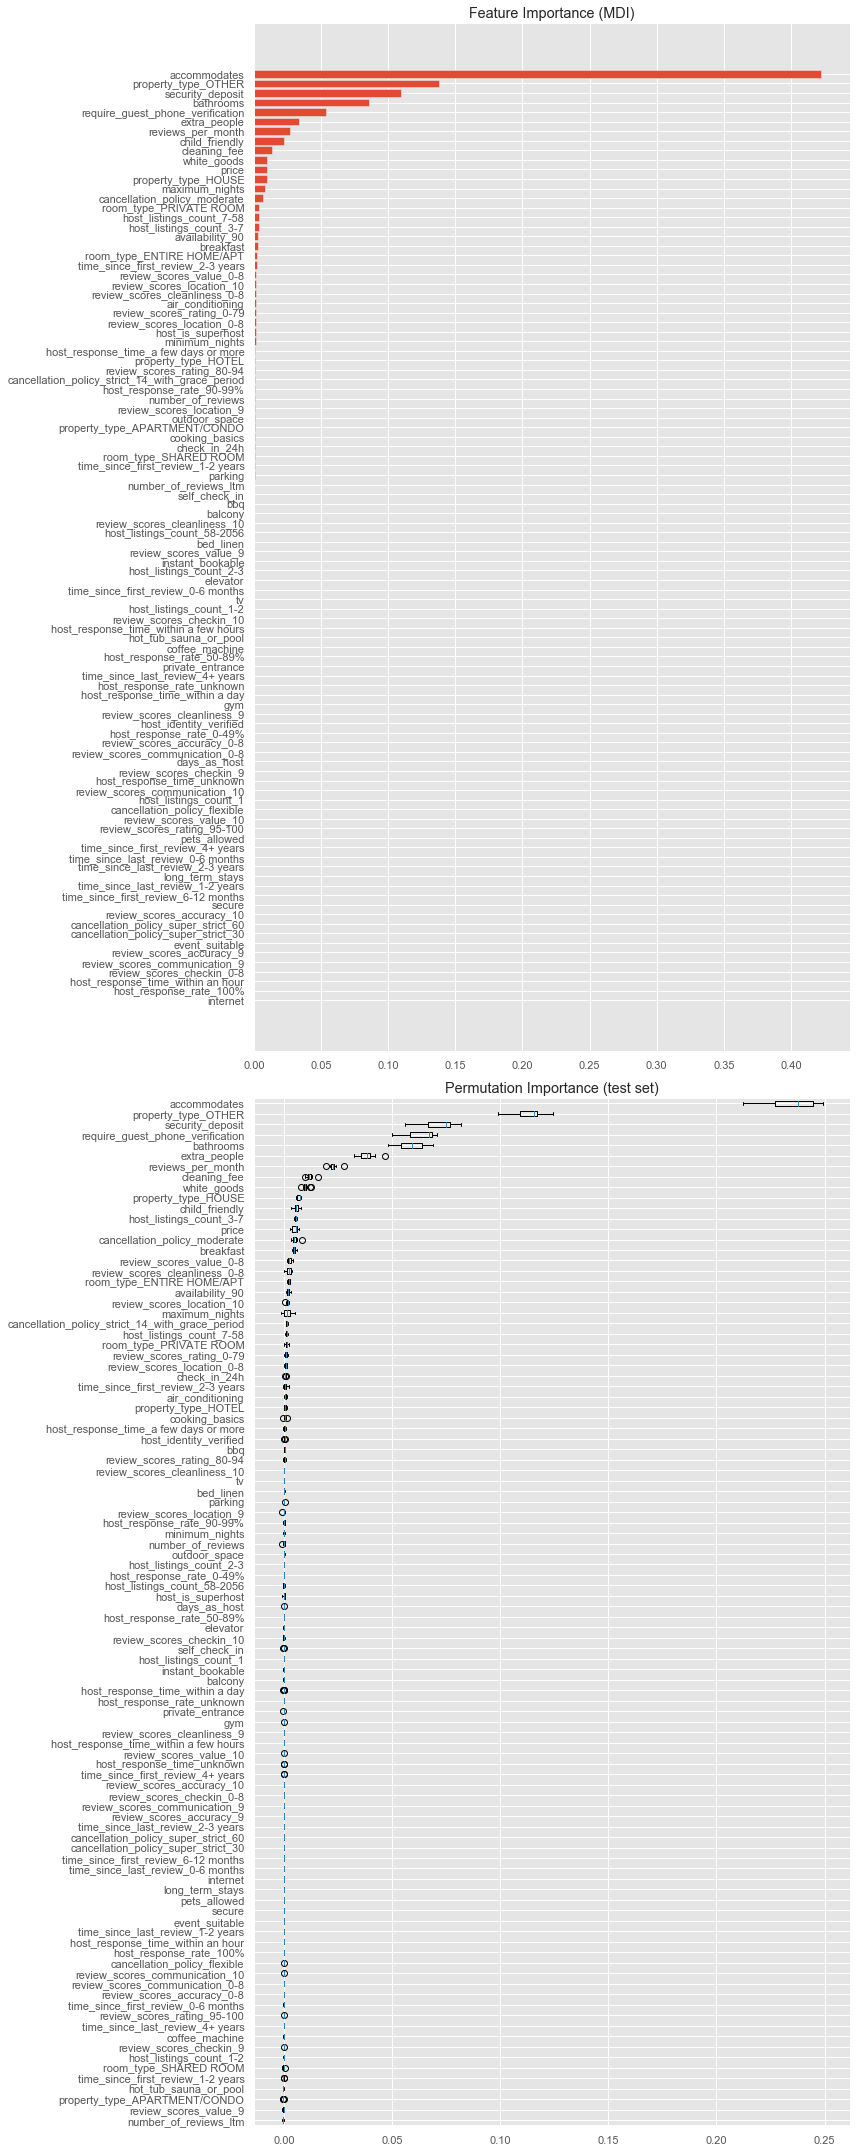

In [225]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 30))
plt.subplot(2, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(encoded_df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(2, 1, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(encoded_df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

#### Model 3: Gradient Boosting using XGBoost

In [230]:
# Setting up and shuffling the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 13)

xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
train_preds = xgb_reg.predict(X_train)
test_preds = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Computational Time: {round((xgb_reg_end - xgb_reg_start),1)} seconds")
print("\nTrain MSE:", round(mean_squared_error(y_train, train_preds),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds),4))
print("\nTrain  R^2:", round(r2_score(y_train, train_preds),4))
print("Test  R^2:", round(r2_score(y_test, test_preds),4))

[21:25:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Computational Time: 0.9 seconds

Train MSE: 0.1961
Test MSE: 0.2111

Train  R^2: 0.7228
Test  R^2: 0.6943


In [231]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True, ascending=True)
ft_weights_xgb_reg

,weight
host_response_rate_unknown,0.000000
event_suitable,0.000000
internet,0.000000
hot_tub_sauna_or_pool,0.000000
host_response_time_a few days or more,0.000000
...,...
air_conditioning,0.035339
cleaning_fee,0.052216
bathrooms,0.106891
accommodates,0.114639


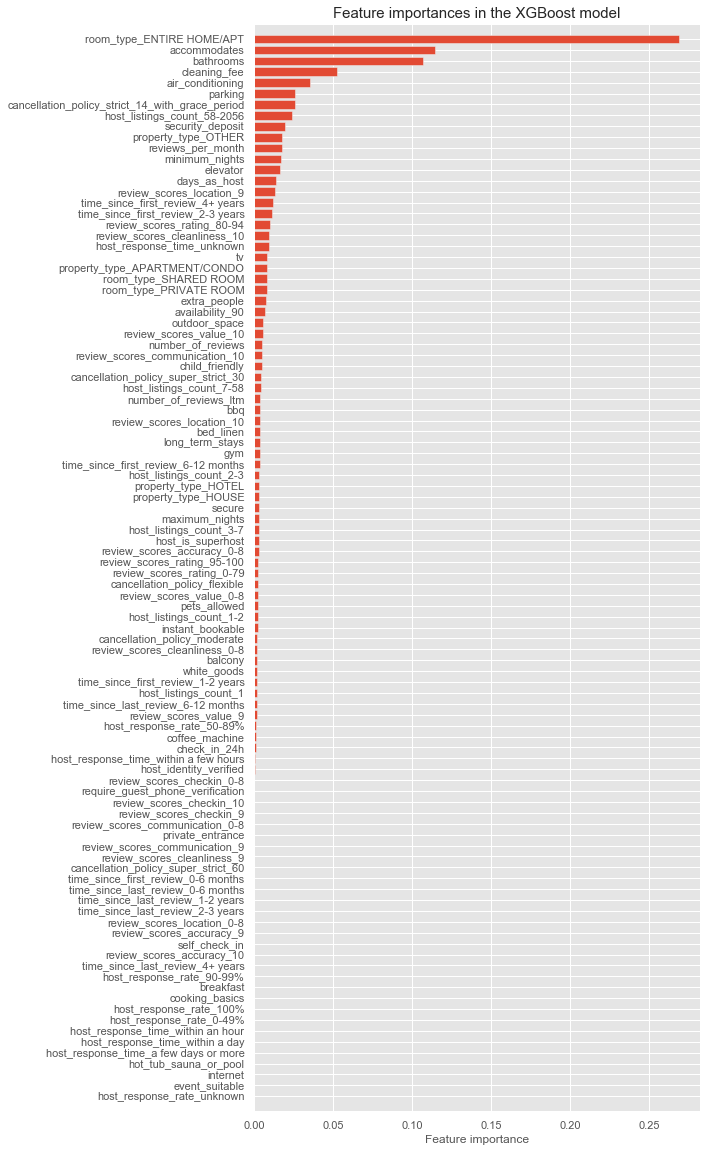

In [232]:
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=15)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

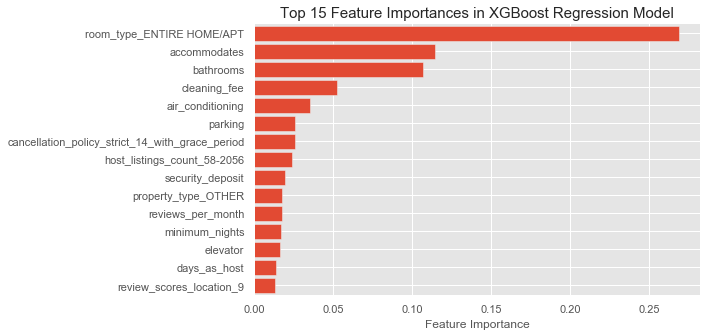

In [233]:
_ = plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.barh(ft_weights_xgb_reg.tail(15).index, ft_weights_xgb_reg.tail(15).weight, align='center') 
plt.title("Top 15 Feature Importances in XGBoost Regression Model", fontsize=15)
plt.xlabel("Feature Importance")
plt.margins(y=0.01)
plt.show()